In [2]:
import pandas as pd
import numpy as np

In [3]:
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import joblib
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import HTML
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Introduction

This notebook is meant to accompany the paper _Model Extrapolation on Malaria Data_ - currently in preparation - so that all results can easily be replicated.

Contents are as follows:
- Data discussion
- Digression on Tanimoto distance
- Bias correction
- MPO optimization


## Data discussion

We have two main datasets.  Firstly - the one avaliable here on chembl gitbook

A. https://chembl.gitbook.io/chembl-ntd/downloads/deposited-set-1-gsk-tcams-dataset-20th-may-2010

We will refer to this henceforth as the **TCAMS dataset**, although it is actually some combination of TCAMS and other Chembl data.  

We also have:

B. The chembl data associated to the malaria assays (downloaded from the webclient, code in Appendix)

We'll refer to this as the **Plasmodium datset**.  In this section we'll talk about the advantages and disadvantages of each dataset - and how we can use them together.

Finally we have two quite different datasets - which we will use for the purposes of sanity checking the datasets above, and testing - insofar as we can - the predictions we make from them:

C.  A list of 7 well-known malaria drugs.

D.  Roughly 7.5 million commercially available compounds from Molport.

We now describe how we construct our modelling datasets.

In [4]:
df_tcams = pd.read_pickle('parsed/chembl_tcams.pkl')
df_plas = pd.read_pickle('parsed/chembl_isidro.pkl')

The TCAMS data has two columns that will be of main interest to us:
- pXC50_3D7: pIC50 values against the (3D7) strain of _Plasmodium Falciparum_.  Henceforth we will refer to this value (and the similar variable available in the Plasmodium dataset) as **Potency**.
- PCT_INHIB_HEPG2: percent inhibition against HEPG2 cells, henceforth referred to as **Toxicity**.

The Plasmodium dataset only has potency values.

Both datsets have Chembl compound IDs and SMILES associated to them.  To both datasets we associate canonical smiles as calculated by our own standardiser software, to ensure uniqueness.  From these canonical smiles we then separately calculate 128 bit _binary fingerprints_ and 128 bit _hashed fingerprints_.  These will be the predictors used in the subsequent analysis.  We also use these canonical smiles to look at the uniqueness and overlap between these two datasets, which we now describe.

#### Potency, selection, uniqueness and overlap in TCAMS and Plasmodium datasets

Following list of facts about TCAMS datsets is inferred from code run below:

In [5]:
from malaria import utils, stats
from standardiser import standardise

mrgd_df = pd.merge(df_plas.groupby('SMILESIS').mean(), 
                   df_tcams.groupby('SMILESIS').mean(), left_index=True, right_index=True)

tcams_good_pot = np.sum(~np.isnan(df_tcams.groupby('SMILESIS').mean()['pXC50_3D7'].values))
tcams_good_tox = np.sum(~np.isnan(df_tcams.groupby('SMILESIS').mean()['PCT_INHIB_HEPG2'].values))

print('TCAMS rows                              %d' % df_tcams.shape[0])
print('TCAMS unique Canonical smiles:          %d' % np.unique(df_tcams.SMILESIS.values).shape[0])
print('TCAMS unique CS with value for potency  %d' % tcams_good_pot)
print('TCAMS unique CS with value for toxicity %d' % tcams_good_tox)
print('')
print('PLASM rows                              %d' % df_plas.shape[0])
print('PLASM unique CS (all have potency val)  %d' % np.unique(df_plas.SMILESIS.values).shape[0])
print('')
print('Number unique CS in TCAMS AND PLASM     %d' % mrgd_df.shape[0])
print('')
print('Regression of POT on intersection TCAMS/PLASM')
# Halleluiah!  We can pretend they are the same!!!
gd = ~np.isnan(mrgd_df.pXC50_3D7.values)
stats.regress(mrgd_df.VAL.values[gd], [mrgd_df.pXC50_3D7.values[gd],])

TCAMS rows                              26784
TCAMS unique Canonical smiles:          21005
TCAMS unique CS with value for potency  13327
TCAMS unique CS with value for toxicity 13237

PLASM rows                              23864
PLASM unique CS (all have potency val)  18162

Number unique CS in TCAMS AND PLASM     13090

Regression of POT on intersection TCAMS/PLASM
Coeffs:       1.0004 
R-squared:    0.9749


In [6]:
#gd = ~np.isnan(df_tcams.pXC50_3D7.values)
#full_df = pd.DataFrame.from_dict({'SMILESIS' : list(df_plas.SMILESIS.values) + list(df_tcams.SMILESIS.values[gd]), 
#                                 'POTENCY'  : list(df_plas.VAL.values) + list(df_tcams.pXC50_3D7.values[gd]),
#                                 })
#full_df = full_df.groupby('SMILESIS').mean()
#fps = [utils.get_fp(x) for x in full_df.index]
#full_df['fps'] = pd.Series([np.asarray(fp).astype(bool) for fp in fps], index=full_df.index)
#hfps = [utils.get_fp(x, hashed=True) for x in full_df.index]
#full_df['hfps'] = pd.Series([np.asarray(fp) for fp in hfps], index=full_df.index)
#crippen = pd.Series([utils.get_crippen(Chem.MolFromSmiles(x)) for x in full_df.index], index=full_df.index)
#qed = pd.Series([utils.get_qed(Chem.MolFromSmiles(x)) for x in full_df.index], index=full_df.index)
#full_df['crippen'] = crippen
#full_df['qed'] = qed
#full_df.to_pickle('joined_chembl_data.pkl')
full_df = pd.read_pickle('joined_chembl_data.pkl')

We should make some further comments about the potency data before going any further.

In the TCAMS dataset, there are no values for potency below ~ 5.3.  This might lead one to think that any missing potency data is inactive.  However - this would be a bad assumption.  We checked for the best current known anti-malarial drugs (described in the next section).  All of these bar one (Doxycycline) are in the TCAMS dataset, **however**, **only two** have non-nan potency values (Chloroquine has two) - and the most potent known drug, Artemisinin has no potency value assigned.

Therefore it is clear that adding data to the TCAMS dataset is going to be necessary, but given its biases, our overall dataset will still be heavily biased, and in particularly very strongly biased towards predicting potency values that are unreasonably high.

Below we show the potency histogram of our full merged dataset:

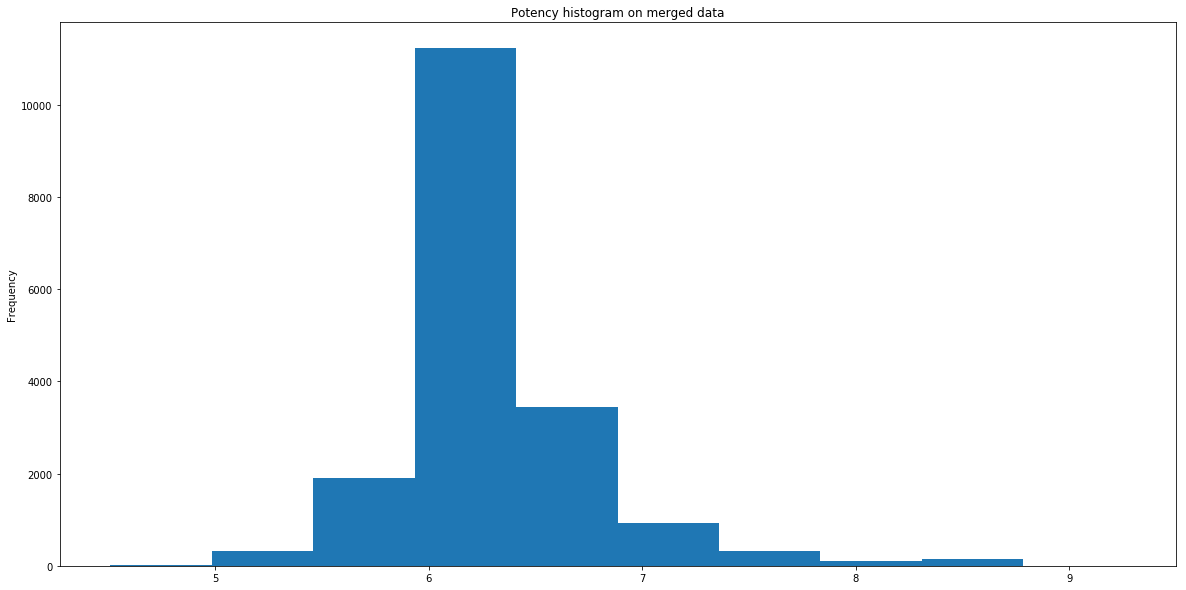

In [7]:
# Figure pot_hist in the paper.
figsize(20,10)
full_df.POTENCY.plot.hist()
_ = plt.title('Potency histogram on merged data')

### Tanimoto distance

As we will explain in later sections - a key issue is to understand the effect of Tanimoto distance between datapoints in the training set and datapoints in the test set.  

Let's look at the minimum distance of a 'random' commercially available molecule to the malaria training set.  We take a randomly selected 500K molecules from our Molport dataset, add the minumum distance to the Malaria set, and plot the histogram of these values...

In [8]:
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')
#for fn in std_files[1:]:
#    add_min_dist(fn)

In [9]:
mp_df = pd.read_pickle(std_files[1])

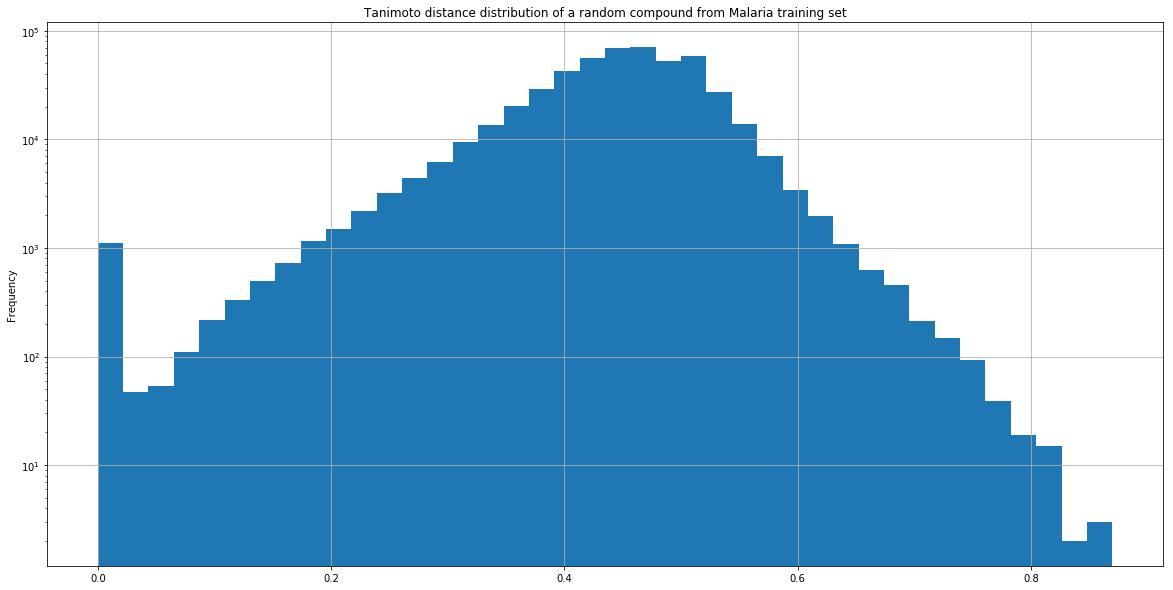

In [10]:
mp_df.min_dist.plot.hist(bins=40, log=True)
grid(True)
_ = plt.title('Tanimoto distance distribution of a random compound from Malaria training set')

We also need to estimate from our data what the covariance of the potency values is as a function of the Tanimoto distance between two datapoints.

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less_equal


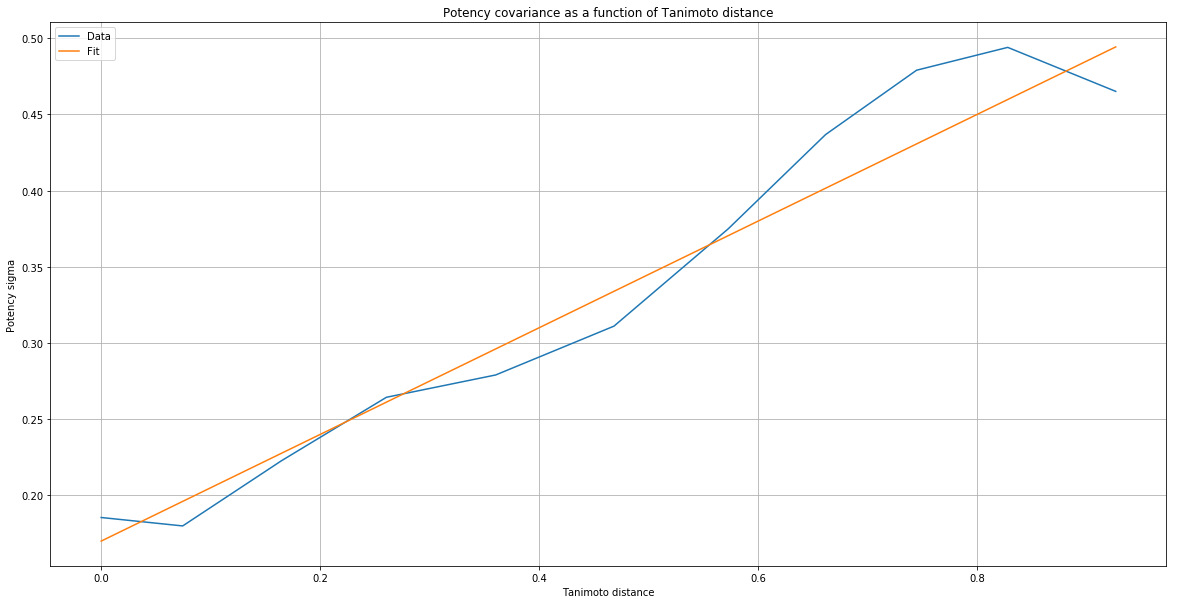

In [11]:
from scipy.spatial.distance import cdist

estimates_hdr = {}
weight_hdr = {}
ctr_hdr = {}

fpa = np.asarray([x for x in full_df.fps.values])
bins = [-0.001, 0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in range(len(bins)-1):
    estimates_hdr[i] = []
    weight_hdr[i] = []
    ctr_hdr[i] = []
    pass

for i in range(full_df.shape[0]):
    v = [full_df.POTENCY.values[i]]
    dists = cdist(np.asarray([full_df.fps.values[i],]), fpa, metric='jaccard')[0]
    dists[i]+=2 # to exclude from anything
    
    for j in range(len(bins)-1):
        bstart = bins[j]
        bend = bins[j+1]
        gd = (dists > bstart) & (dists <= bend)
        gpot = full_df.POTENCY.values[gd]
        if len(gpot) == 0:
            continue

        gpot = np.concatenate((v, gpot))
        estimates_hdr[j].append(np.std(gpot, ddof=1))
        weight_hdr[j].append(gpot.shape[0]-1)
        ctr_hdr[j].append(np.mean(dists[gd]))
        pass
    pass     


ctrs = np.asarray([np.average(ctr_hdr[i], weights=weight_hdr[i]) for i in range(len(bins)-1)])
sigmas = np.asarray([np.average(estimates_hdr[i], weights=weight_hdr[i]) for i in range(len(bins)-1)])
plt.plot(ctrs, sigmas, label='Data'); grid(True); xlabel('Tanimoto distance'); ylabel('Potency sigma')
plt.plot(ctrs, 0.17+0.35*ctrs, label='Fit')
legend(loc='best')
# Figure pot_cov in the paper.
_ = title('Potency covariance as a function of Tanimoto distance')
savefig('figures/covariance.png')

### Bias correction for model extrapolation

Overview.
In order to correct our models for the bias of the dataset we have obtained we need to make some assumptions about the compounds that were tested and found to be inactive.  For instance - if we assumped (in absurdis) that _all_ compounds other then than the ones in our dataset had been tested against _Plasmodium Falciparum_ and found to be inactive, then the 'model' would be simple:  if a compound is in our dataset - look up the value.  If it isn't - then return the inactive value.

We will make the following assumptions - and then comment on their plausibility, and, more importantly, on the sensitivity of our conclusions to these

Assumptions.  
- We assume that a 'random' molecule has probability 1/100 of being active against _Plasmodium Falciparum_.  This would correspond with our dataset (of 18K actives) having been obtained by screening 2M compounds, and only reporting the active, successful (non spoilt data) tests.  This is roughly the expected size of such a screen.  The actual values of the predictions are somewhat sensitive to this value, but they are not particularly sensitive to it in relative space, since this value operates (to first approximation) like a scaling factor.
- We assume that an inactive molecule has a pIC50 value of 3.5 (taken from talking to chemists).  This is quite an important value, as making it smaller will decrease the extrapolative power of our models as Tanimoto distance from the the dataset increases.
- We assume (for simplicity in our calculations) that our model (fit on the actives) always predicts 6.5 (roughly the mean active value).  This is purely to make the calculations easier - and our results are not sensitive to this.
- We assume that our model is 'well calibrated' for active molecules.  I.e. that if our model predicts potencty m for some compound c, then E(Pot(c) | c is Active) = m.  Figure (insert ref) shows that this is not true if c is sufficiently far from our training dataset, but that we should shrink the predicted value towards the mean active value.  Since (for the purposes of 

Now we can put everything together to build our extrapolative model.

First we fit our model M on the active data.  For some unseen compoound c, suppose our model predicts potency of m.  Suppose also that D - the minimum Tanimoto distance between c and our fit dataset is d.  We want to know:

(1) E(Pot(c) |  M(c) = m, D(c) = d)

We assumed that our model is well-calibrated, so this is equal to:

let 

(2) p = P(c is Inactive | M(c) = m, D(c) = d)

then we can rewrite (1) as:

p.Inactive_value  + (1-p) m

The key question therefore is to calculate p.  Let Q be our prior that c is inactive.  Then the posterior that c is inactive given the information (M(c) = m, D(c) = d) should be (assuming normal distributions everywhere):

W / (W + 1 - Q)

where W = Q exp(-(Inactive_value - m)^2 / sigma(pot(c) | d))

Note that we can form an estimate of sigma(pot(c) | d) from our potency covariance model estimated on the data.

Finally we note that Avg(c in random_molecules) {p(c | M(c) = m, D(c) = d} = 0.01

(which, assuming M(c) = 6.5 for all molecules, and integrating over the empirical distribution of D shown in the histogram above, allows us to estimate Q!


In [12]:
from functools import partial
sigma_func = partial(np.interp, xp=ctrs, fp=sigmas)

In [13]:
sigma_func(0)

0.18547647882731794

In [14]:
d_hist = np.histogram(mp_df.min_dist.values[~np.isnan(mp_df.min_dist.values)], bins=40)

In [15]:
def avg_prob_active(d_hist, sigma_func, prior_prob=0.1, inactive_val=3.5, model_val=6.5):
    
    dh_counts = d_hist[0]
    d_bins = d_hist[1]
    bin_centres = 0.5 * (d_bins[1:] + d_bins[:-1])
    sigmas = sigma_func(bin_centres)
    
    diff = model_val - inactive_val
    count = 0
    expected_actives = 0
    
    for i in range(len(dh_counts)):
        
        count += dh_counts[i]
        sigma = sigmas[i]
        
        w = (1-prior_prob)*np.exp(-(diff/sigma)**2/2)
        prob_active = prior_prob / (prior_prob + w)
        print(dh_counts[i], diff/sigma, prob_active)
        expected_actives += dh_counts[i] * prob_active
    
    return expected_actives/count

In [16]:
#avg_prob_active(d_hist=d_hist, sigma_func=sigma_func, prior_prob=2e-13, model_val=6., inactive_val=4)

In [17]:
avg_prob_active(d_hist=d_hist, sigma_func=sigma_func, prior_prob=5e-11)

(1105, 16.245263312615748, 1.0)
(47, 16.388545490706456, 1.0)
(54, 16.534377638566337, 1.0)
(109, 16.5990919900267, 1.0)
(216, 15.703395086482963, 1.0)
(329, 14.899413830141196, 1.0)
(496, 14.173747364366356, 1.0)
(732, 13.515484305111965, 1.0)
(1168, 12.960435974263129, 1.0)
(1492, 12.452311610417764, 1.0)
(2204, 11.98252695960063, 1.0)
(3196, 11.54690048462149, 1.0)
(4419, 11.277752367625064, 1.0)
(6240, 11.144124281737813, 1.0)
(9498, 11.013625784844745, 0.99999999999999989)
(13598, 10.886148206349699, 0.99999999999999967)
(20134, 10.761587849334248, 0.99999999999999856)
(29351, 10.526670042441731, 0.99999999999998268)
(42608, 10.293794689186468, 0.99999999999980427)
(55758, 10.070999860369614, 0.99999999999810818)
(68975, 9.8576448857303074, 0.99999999998414579)
(70950, 9.6531422593293925, 0.99999999988343591)
(52301, 9.2642774654079147, 0.99999999538715201)
(58557, 8.898707375768474, 0.99999987241697363)
(27027, 8.5608929675507905, 0.99999756471928758)
(13931, 8.2477888511655397, 

0.9969884225543173

In [18]:
avg_prob_active(d_hist=d_hist, sigma_func=sigma_func, prior_prob=5e-11)

(1105, 16.245263312615748, 1.0)
(47, 16.388545490706456, 1.0)
(54, 16.534377638566337, 1.0)
(109, 16.5990919900267, 1.0)
(216, 15.703395086482963, 1.0)
(329, 14.899413830141196, 1.0)
(496, 14.173747364366356, 1.0)
(732, 13.515484305111965, 1.0)
(1168, 12.960435974263129, 1.0)
(1492, 12.452311610417764, 1.0)
(2204, 11.98252695960063, 1.0)
(3196, 11.54690048462149, 1.0)
(4419, 11.277752367625064, 1.0)
(6240, 11.144124281737813, 1.0)
(9498, 11.013625784844745, 0.99999999999999989)
(13598, 10.886148206349699, 0.99999999999999967)
(20134, 10.761587849334248, 0.99999999999999856)
(29351, 10.526670042441731, 0.99999999999998268)
(42608, 10.293794689186468, 0.99999999999980427)
(55758, 10.070999860369614, 0.99999999999810818)
(68975, 9.8576448857303074, 0.99999999998414579)
(70950, 9.6531422593293925, 0.99999999988343591)
(52301, 9.2642774654079147, 0.99999999538715201)
(58557, 8.898707375768474, 0.99999987241697363)
(27027, 8.5608929675507905, 0.99999756471928758)
(13931, 8.2477888511655397, 

0.9969884225543173

In [19]:
sigmas

array([ 0.18547648,  0.17994846,  0.22269171,  0.26435589,  0.27899073,
        0.3110225 ,  0.37484338,  0.43672254,  0.47894315,  0.49392299,
        0.46505729])

In [20]:
def prob_active(sigma, prior_prob=5e-11, inactive_val=3.5, model_val=6.5):
    diff = model_val - inactive_val
    w = (1-prior_prob)*np.exp(-(diff/sigma)**2/2)
    return prior_prob / (prior_prob + w)

In [21]:
np.arange(0, 1, 0.1)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


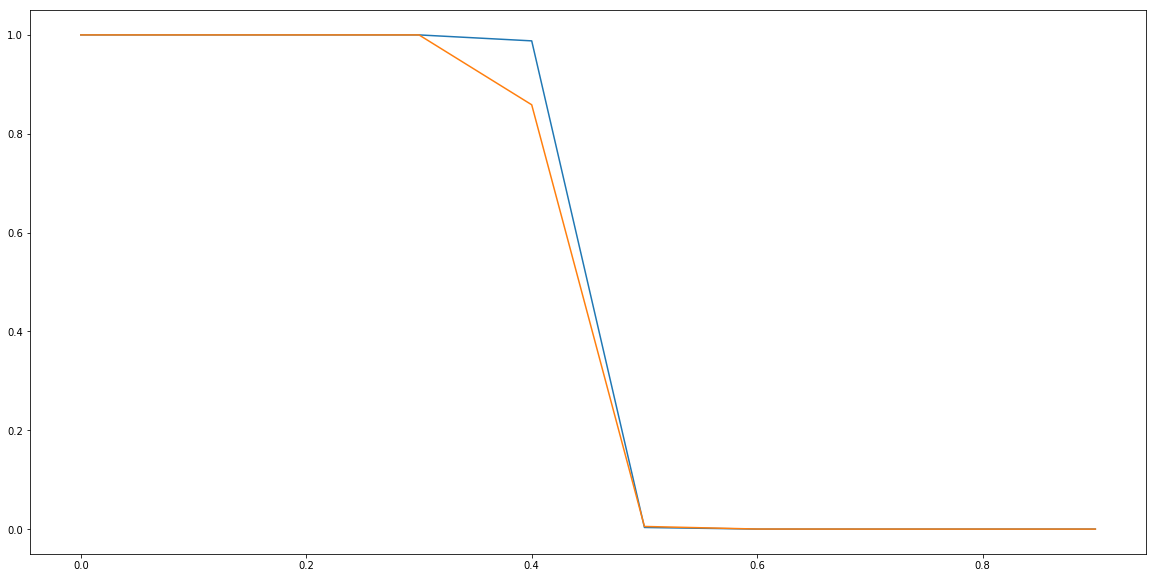

In [22]:
plot(np.arange(0, 1, 0.1), prob_active(np.arange(0, 1, 0.1)))
plot(np.arange(0, 1, 0.1), prob_active(np.arange(0, 1, 0.1),model_val=6, prior_prob=2e-8))

In [23]:
p_hist = np.histogram(full_df.POTENCY.values, bins=10)

In [24]:
import pdb

In [25]:
def avg_prob_active2(d_hist, p_hist, sigma_func, prior_prob=0.1, inactive_val=3.5):
    
    dh_counts = d_hist[0]
    p_counts = p_hist[0]
    d_bins = d_hist[1]
    bin_centres = 0.5 * (d_bins[1:] + d_bins[:-1])
    pbin_centres = 0.5 * (p_hist[1][1:] + p_hist[1][:-1])
    sigmas = sigma_func(bin_centres)

    count = 0.0
    expected_actives = 0
    
    for i in range(len(dh_counts)):
        for j in range(len(p_counts)):
            
            diff = pbin_centres[j] - inactive_val
            count += dh_counts[i]*p_counts[j]
            sigma = sigmas[i]
        
            w = (1-prior_prob)*np.exp(-(diff/sigma)**2/2)
            prob_active = prior_prob / (prior_prob + w)
            #pdb.set_trace()
        
            expected_actives += dh_counts[i]*p_counts[j]* prob_active 
            pass
        pass
    
    return expected_actives/count

In [26]:
avg_prob_active2(d_hist, p_hist, sigma_func, prior_prob=1e-60, inactive_val=3.5)

0.0049812373010508348

### The other approach...

In [27]:
tc_dists = cdist(fpa, fpa, metric='jaccard') + np.diag(np.ones(len(fpa)) * np.nan)

In [28]:
import glob
std_files = glob.glob('/Users/oliverwatson/evartech/molport/standardn_*')

In [29]:
df0 = pd.read_pickle(std_files[0])

In [30]:
idcs = np.random.choice(np.arange(df0.shape[0]), 10000)

In [31]:
fpr = np.asarray([x for x in df0.iloc[idcs].fps.values])

In [32]:
r_dists = cdist(fpr, fpr, metric='jaccard') + np.diag(np.ones(len(fpr)) * np.nan)

In [33]:
tcr_dists = cdist(fpr, fpa, metric='jaccard')

In [34]:
tcr_dists.shape

(10000, 18425)

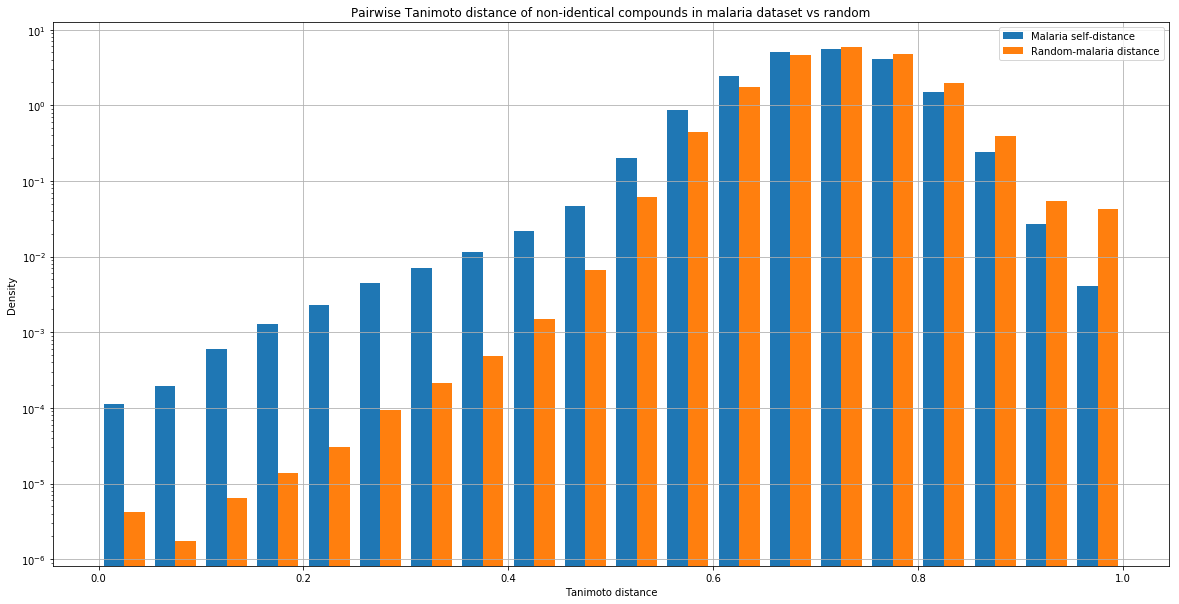

In [35]:
plt.hist((tc_dists[~np.isnan(tc_dists)],tcr_dists[~np.isnan(tcr_dists)]), 
         bins=20, density=True, label=('Malaria self-distance', 'Random-malaria distance'))
#plt.hist(r_dists[~np.isnan(r_dists)], bins=20, label='Random distances')
plt.yscale('log')
plt.xlabel('Tanimoto distance')
plt.ylabel('Density')
grid('True')
legend(loc='best')
_ = plt.title('Pairwise Tanimoto distance of non-identical compounds in malaria dataset vs random')
savefig('figures/malaria_clustering_in_tanimoto_space.png')

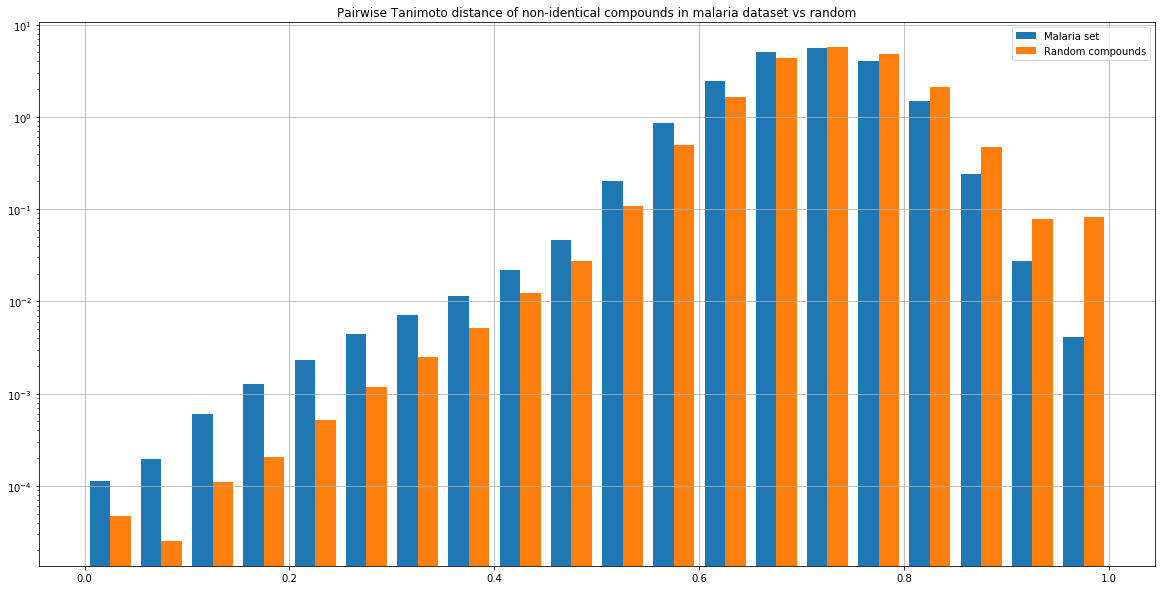

In [36]:
plt.hist((tc_dists[~np.isnan(tc_dists)],r_dists[~np.isnan(r_dists)]), 
         bins=20, density=True, label=('Malaria set', 'Random compounds'))
#plt.hist(r_dists[~np.isnan(r_dists)], bins=20, label='Random distances')
plt.yscale('log')
grid('True')
legend(loc='best')
_ = plt.title('Pairwise Tanimoto distance of non-identical compounds in malaria dataset vs random')

In [37]:
mal_hist= np.histogram(tc_dists[~np.isnan(tc_dists)], density=True, bins=7)

In [38]:
rand_hist = np.histogram(r_dists[~np.isnan(r_dists)], density=True, bins=5)

In [39]:
mr_hist = np.histogram(tcr_dists[~np.isnan(tcr_dists)], density=True, bins=7)

In [40]:
x_axis = 0.5*(mal_hist[1][1:] + mal_hist[1][:-1])

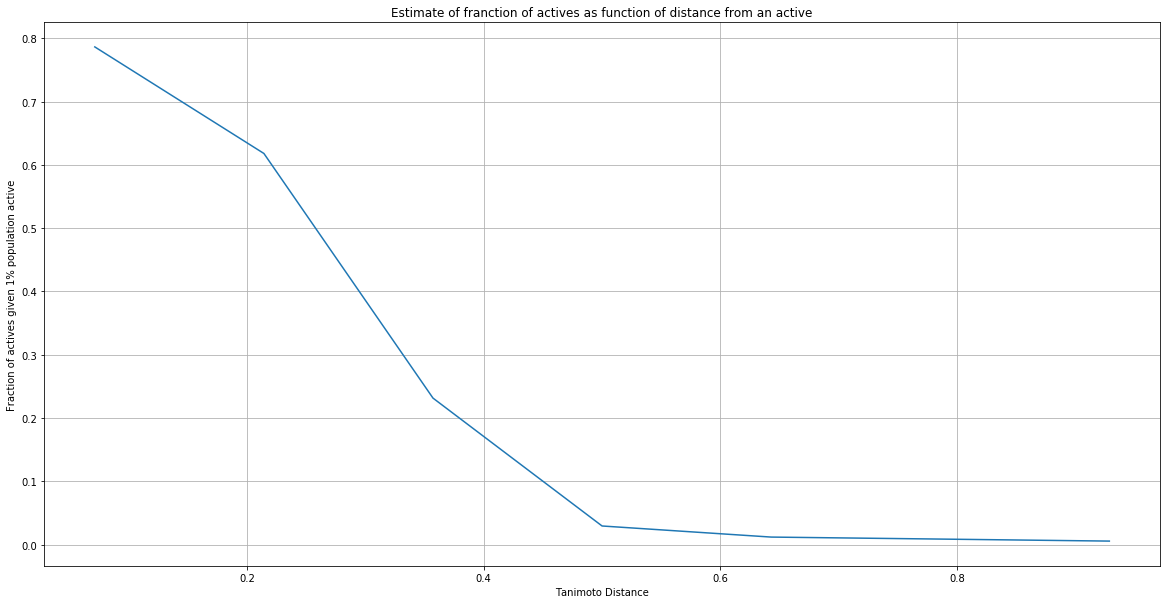

In [41]:
plot(x_axis, mal_hist[0]/(100*mr_hist[0]))
grid(True)
plt.xlabel('Tanimoto Distance')
plt.ylabel('Fraction of actives given 1% population active')
_ = plt.title('Estimate of franction of actives as function of distance from an active')
savefig('figures/inactive_fraction.png')

In [42]:
result_hdr = joblib.load('results/summary_results')

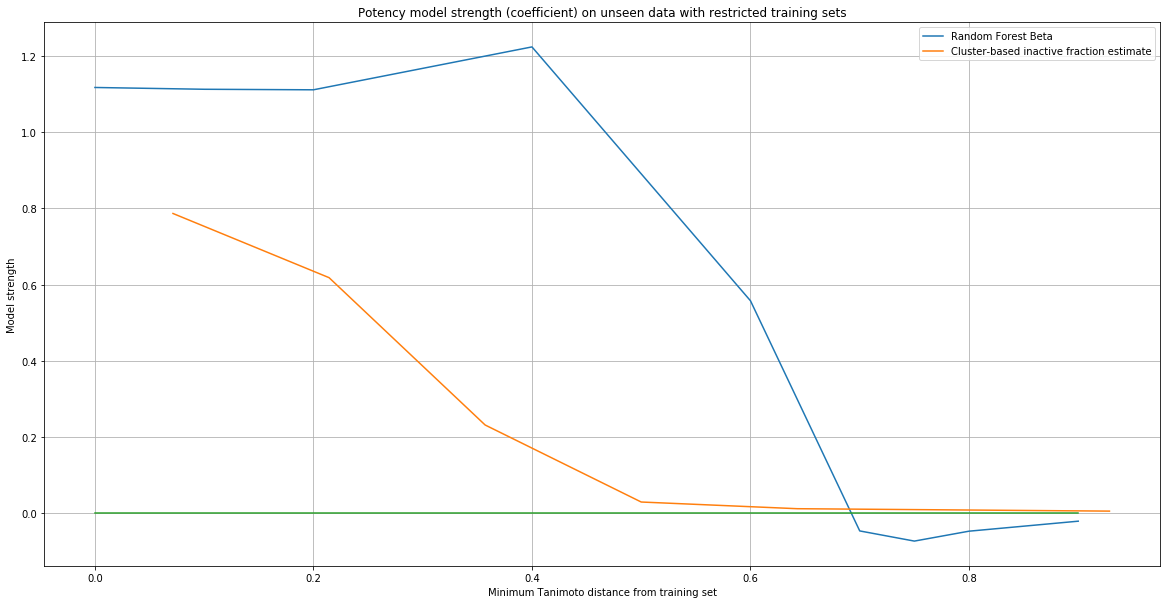

In [43]:
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.75, 0.8, 0.9]
plot(bins, result_hdr['rfb'], label='Random Forest Beta')
plot(x_axis, mal_hist[0]/(100*mr_hist[0]), label='Cluster-based inactive fraction estimate')
plot(bins, np.zeros(len(bins)))
xlabel('Minimum Tanimoto distance from training set')
ylabel('Model strength')
grid(True); legend(loc='best')
_ = title('Potency model strength (coefficient) on unseen data with restricted training sets')
savefig('figures/beta_res_pot.png')

Final model!  Ok, so we have two things we need:  The Cluster-based active fraction estimate (capped at 1.0) and the Random forest beta conditional on being active.

Model is Frac_active() * (RF_prediction * RF_beta + (1-RF_beta) * active_level) + (1-Frac_active) * inactive_level


- Note - this simplifies as:



In [44]:
from functools import partial

In [45]:
frac_active = partial(np.interp, xp=x_axis, fp=(mal_hist[0]/(100*mr_hist[0])).clip(0., 1.))

In [46]:
inactive_level = 3.5

In [47]:
active_level = np.mean(full_df.POTENCY.values)

In [48]:
rf_beta = partial(np.interp, xp=bins, fp=result_hdr['rfb'])

In [49]:
mp_df = pd.read_pickle(std_files[0])

In [50]:
mp_df.min_dist[:10]

0    0.428571
1    0.500000
2    0.487805
3    0.631579
4    0.606061
5    0.481481
6    0.585366
7    0.589286
8    0.484848
9    0.296296
Name: min_dist, dtype: float64

In [51]:
frac_active(mp_df.min_dist[:10])

array([ 0.13034039,  0.02927295,  0.04652837,  0.01312745,  0.0162587 ,
        0.05547562,  0.01879807,  0.01831708,  0.0507115 ,  0.39609005])

In [52]:
rf_beta(mp_df.min_dist[:10])

array([ 1.12841183,  0.89048128,  0.93110357,  0.36665209,  0.52077446,
        0.95216698,  0.60612526,  0.5930681 ,  0.9409514 ,  1.16522099])

In [53]:
# first fit full models....
reload(stats)
df_tcams_nd = pd.read_pickle('parsed/tcams_nodups.pkl')
full_models = stats.fit_models(df_tcams_nd, full_df)
from malaria import mp_utils

In [54]:
full_models['power']['rf'].predict(np.asarray([fp for fp in mp_df.fps[:10]]))

array([ 6.20807554,  6.24815953,  6.18928906,  6.30592773,  6.22444003,
        6.17477407,  6.18329928,  6.20129784,  6.23863523,  6.20301992])

In [55]:
fa = frac_active(mp_df.min_dist[:10])
rfb = rf_beta(mp_df.min_dist[:10])
rfp = full_models['power']['rf'].predict(np.asarray([fp for fp in mp_df.fps[:10]]))
model = fa * (rfb * rfp + (1-rfb)*active_level) + (1-fa)*inactive_level

In [56]:
model

array([ 3.85200161,  3.58050403,  3.62537424,  3.53650298,  3.54461992,
        3.64862691,  3.5510534 ,  3.54996239,  3.63896233,  4.56651567])

In [57]:
full_models['rfb'] = rf_beta
full_models['frac_act'] = frac_active
full_models['inactive_level'] = inactive_level
full_models['active_level'] = active_level

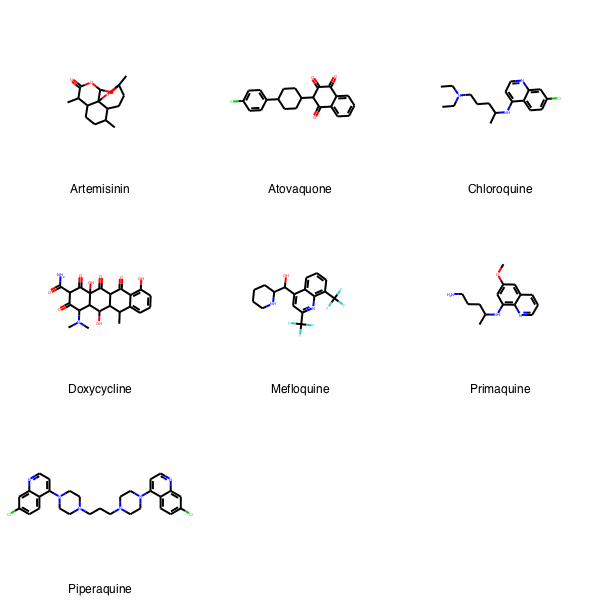

In [58]:
Artemisinin = 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C'
Atovaquone  = 'C1CC(CCC1C2=CC=C(C=C2)Cl)C3=C(C4=CC=CC=C4C(=O)C3=O)O'
Chloroquine = 'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl'
Doxycycline = 'CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O'
Mefloquine  = 'C1CCNC(C1)C(C2=CC(=NC3=C2C=CC=C3C(F)(F)F)C(F)(F)F)O'
Primaquine  = 'CC(CCCN)NC1=C2C(=CC(=C1)OC)C=CC=N2'
Piperaquine = 'C1CN(CCN1CCCN2CCN(CC2)C3=C4C=CC(=CC4=NC=C3)Cl)C5=C6C=CC(=CC6=NC=C5)Cl'
drugs = [Artemisinin, Atovaquone, Chloroquine, Doxycycline, Mefloquine, Primaquine, Piperaquine]
drugs = [standardise.run(drug) for drug in drugs]
drug_labels = ['Artemisinin', 'Atovaquone', 'Chloroquine', 
               'Doxycycline', 'Mefloquine', 'Primaquine', 'Piperaquine']

Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in drugs], 
                          legends=drug_labels)

In [59]:
reload(mp_utils)
mp_utils.get_best(full_models, drugs=drugs)

1


malaria/mp_utils.py:177: RuntimeWarning: invalid value encountered in greater
  ollie[crippen > log_p_thresh] = 0
malaria/mp_utils.py:183: RuntimeWarning: invalid value encountered in less
  ollie[qed < qed_thresh] = 0


2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [60]:
reload(mp_utils)
pic = mp_utils.summarize('POT', 5)

In [61]:
pic.save('figures/most_potent.png')

In [62]:
sm, lbls = mp_utils.summarize('POT', 10, neighbours=True, draw=False)

In [63]:
full_df[full_df.index.isin(sm)]

,POTENCY,fps,hfps,crippen,qed
SMILESIS,,,,,
CC1(C)N=C(N)N=C(N)N1OCC=Cc1ccccc1,8.373020,"[False, False, False, False, False, True, Fals...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.3125,0.865276
CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4,8.315000,"[False, True, False, False, False, False, Fals...","[0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, ...",2.1867,0.690996
CCCOC(=O)C1=C(C)NC2=C(C(=O)CC(c3ccc(OC)c(OC)c3)C2)C1c1ccc(Cl)cc1Cl,8.240000,"[True, True, False, True, False, False, False,...","[3, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 2, 1, 1, 1, ...",6.3254,0.422349
CC[C@@H](C(=O)[C@@H](C)[C@@H](O)[C@H](C)[C@@H]1O[C@@H]([C@@H](CC)C(=O)O)CC[C@@H]1C)[C@H]1O[C@]2(C=C[C@@H](O)[C@]3(CC[C@@](C)([C@H]4CC[C@](O)(CC)[C@H](C)O4)O3)O2)[C@H](C)C[C@@H]1C,8.700000,"[False, True, True, False, False, True, False,...","[0, 7, 3, 0, 0, 1, 0, 0, 2, 1, 5, 0, 1, 0, 0, ...",6.1880,0.168543
CC[C@@]1([C@@H]2O[C@@H]([C@H]3O[C@@](O)(CO)[C@H](C)C[C@@H]3C)C[C@@H]2C)CC[C@H]([C@]2(C)CC[C@]3(C[C@H](O)[C@@H](C)[C@@H]([C@@H](C)[C@@H](OC)[C@H](C)C(=O)O)O3)O2)O1,9.220000,"[False, True, True, False, False, True, True, ...","[0, 4, 1, 0, 0, 4, 1, 1, 0, 0, 4, 1, 2, 0, 0, ...",4.2729,0.263607
CC[C@H](C)[C@H](NC(=O)[C@H]([C@@H](C)CC)N(C)C(C)=O)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)[C@@]1(C)CO1)[C@@H](C)O,8.816667,"[True, True, False, False, False, False, False...","[5, 8, 0, 0, 0, 0, 0, 0, 2, 0, 6, 1, 0, 0, 0, ...",1.1648,0.208561
CC[C@H]1CN2CCc3cc(OC)c(OC)cc3[C@@H]2C[C@@H]1C[C@H]1NCCc2cc(O)c(OC)cc21,8.405000,"[True, False, False, True, False, False, False...","[3, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, ...",4.6404,0.646763
COc1ccc(C2CC(=O)C3=C(C2)NC(C)=C(C(=O)OC(C)C)C3c2ccc(Cl)cc2Cl)cc1OC,8.305000,"[True, True, False, True, False, False, False,...","[3, 2, 0, 1, 0, 0, 0, 1, 0, 0, 2, 2, 1, 0, 1, ...",6.3238,0.440742
C[C@@H](COc1ccc(-c2ccccc2)cc1)CON1C(N)=NC(N)=NC1(C)C,8.492425,"[True, True, False, False, False, True, False,...","[2, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, ...",2.9812,0.768168


In [64]:
full_df[full_df.index.isin(sm)].index.values

array(['CC1(C)N=C(N)N=C(N)N1OCC=Cc1ccccc1',
       'CC1CCC2C(C)C(O)OC3OC4(C)CCC1C32OO4',
       'CCCOC(=O)C1=C(C)NC2=C(C(=O)CC(c3ccc(OC)c(OC)c3)C2)C1c1ccc(Cl)cc1Cl',
       'CC[C@@H](C(=O)[C@@H](C)[C@@H](O)[C@H](C)[C@@H]1O[C@@H]([C@@H](CC)C(=O)O)CC[C@@H]1C)[C@H]1O[C@]2(C=C[C@@H](O)[C@]3(CC[C@@](C)([C@H]4CC[C@](O)(CC)[C@H](C)O4)O3)O2)[C@H](C)C[C@@H]1C',
       'CC[C@@]1([C@@H]2O[C@@H]([C@H]3O[C@@](O)(CO)[C@H](C)C[C@@H]3C)C[C@@H]2C)CC[C@H]([C@]2(C)CC[C@]3(C[C@H](O)[C@@H](C)[C@@H]([C@@H](C)[C@@H](OC)[C@H](C)C(=O)O)O3)O2)O1',
       'CC[C@H](C)[C@H](NC(=O)[C@H]([C@@H](C)CC)N(C)C(C)=O)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)C(=O)[C@@]1(C)CO1)[C@@H](C)O',
       'CC[C@H]1CN2CCc3cc(OC)c(OC)cc3[C@@H]2C[C@@H]1C[C@H]1NCCc2cc(O)c(OC)cc21',
       'COc1ccc(C2CC(=O)C3=C(C2)NC(C)=C(C(=O)OC(C)C)C3c2ccc(Cl)cc2Cl)cc1OC',
       'C[C@@H](COc1ccc(-c2ccccc2)cc1)CON1C(N)=NC(N)=NC1(C)C'], dtype=object)

In [73]:
labels = ['P={:.2f} L={:.2f} Q={:.2f}'.format(full_df[full_df.index.isin(sm)].iloc[x].POTENCY, 
                                              full_df[full_df.index.isin(sm)].iloc[x].crippen,
                                              full_df[full_df.index.isin(sm)].iloc[x].qed) 
          for x in range(9)]

In [74]:
labels

['P=8.37 L=1.31 Q=0.87',
 'P=8.32 L=2.19 Q=0.69',
 'P=8.24 L=6.33 Q=0.42',
 'P=8.70 L=6.19 Q=0.17',
 'P=9.22 L=4.27 Q=0.26',
 'P=8.82 L=1.16 Q=0.21',
 'P=8.40 L=4.64 Q=0.65',
 'P=8.30 L=6.32 Q=0.44',
 'P=8.49 L=2.98 Q=0.77']

In [75]:
[Chem.MolFromSmiles(s) for s in full_df[full_df.index.isin(sm)].index.values]

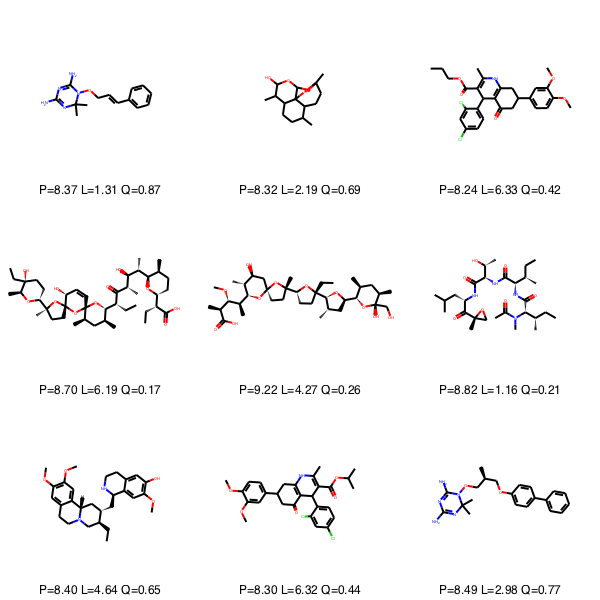

In [76]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in full_df[full_df.index.isin(sm)].index.values], 
                          legends=labels)

In [77]:
pic = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in full_df[full_df.index.isin(sm)].index.values], 
                          legends=labels)
pic.save('figures/most_potent_orig.png')

We looked at just using some reasonable thresholds on toxicity and logP, but the ones we had selected for potency already satisfied these.

However - if we impose a QED threshold of 0.5, then we do find all the various Artemisinin in the molport database, but also some interesting looking related compounds...  This does seem to show that QED does play a valuable screening role.  Again though - we're getting things that are much too similar to existing drugs (Artemisinin in particular)

### Best on Potency, with QED>0.5, LogP<4, predicted(Tox) < 25%

In [78]:
fig = mp_utils.summarize('BEST_Q', 5)
fig.save('figures/best_q.png')

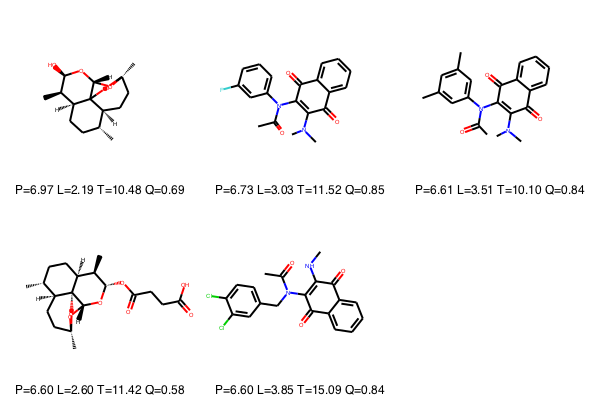

In [79]:
mp_utils.summarize('BEST_Q', 5)

In [80]:
fig = mp_utils.summarize('BEST_Q', 5)
fig.save('figures/best_q.png')

In [81]:
sms = mp_utils.summarize('BEST_Q', 5, draw=False)[0]

In [82]:
sig = Chem.EnumerateStereoisomers.EnumerateStereoisomers(Chem.MolFromSmiles(sms[0]))

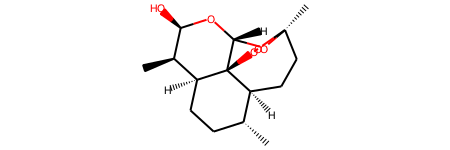

In [83]:
sig.next()

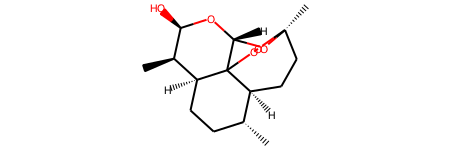

In [84]:
Chem.MolFromSmiles(sms[0])

In [85]:
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions 

In [86]:
m = Chem.MolFromSmiles("BrC=CC1OC(C2)(F)C2(Cl)C1")

In [87]:
isomers = tuple(EnumerateStereoisomers(m)) 

In [88]:
len(isomers)

16

In [89]:
reload(mp_utils)

<module 'malaria.mp_utils' from 'malaria/mp_utils.pyc'>

In [90]:
fig = mp_utils.summarize('POT', 5)
fig.save('figures/most_potent.png')

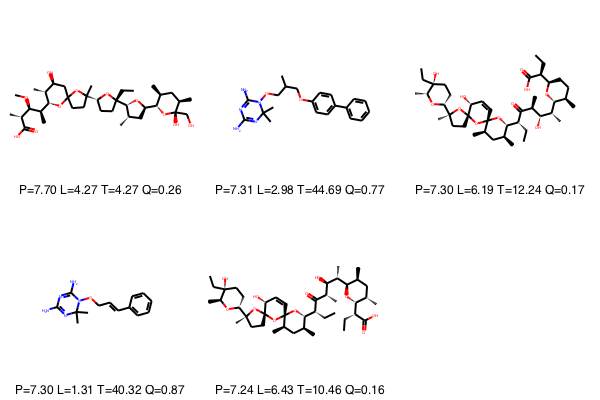

In [91]:
mp_utils.summarize('POT', 5)

In [92]:
mp_utils.summarize('POT', 5, draw=False)[0][0]

'CC[C@@]1([C@@H]2O[C@@H]([C@H]3O[C@@](O)(CO)[C@H](C)C[C@@H]3C)C[C@@H]2C)CC[C@H](C2(C)CCC3(C[C@H](O)[C@@H](C)[C@@H]([C@@H](C)[C@H](OC)[C@@H](C)C(=O)O)O3)O2)O1'

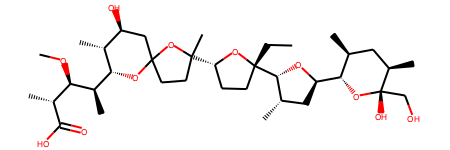

In [93]:
Chem.MolFromSmiles(mp_utils.summarize('POT', 5, draw=False)[0][0])

In [94]:
Chem.MolToSmiles(Chem.MolFromSmiles(mp_utils.summarize('POT', 5, draw=False)[0][0]))

'CCC1(C2OC(C3OC(O)(CO)C(C)CC3C)CC2C)CCC(C2(C)CCC3(CC(O)C(C)C(C(C)C(OC)C(C)C(=O)O)O3)O2)O1'

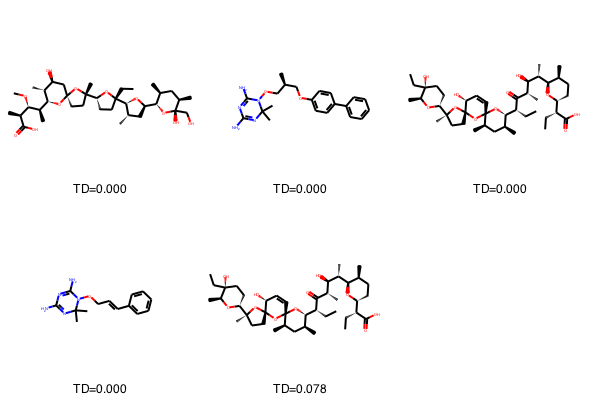

In [95]:
mp_utils.summarize('POT', 5, neighbours=True)

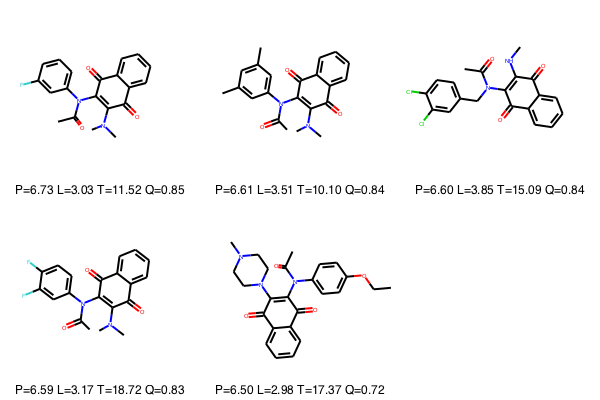

In [96]:
mp_utils.summarize('BEST_D', 5)

In [97]:
fig = mp_utils.summarize('BEST_D', 5)
fig.save('figures/best_dists_fd.png')

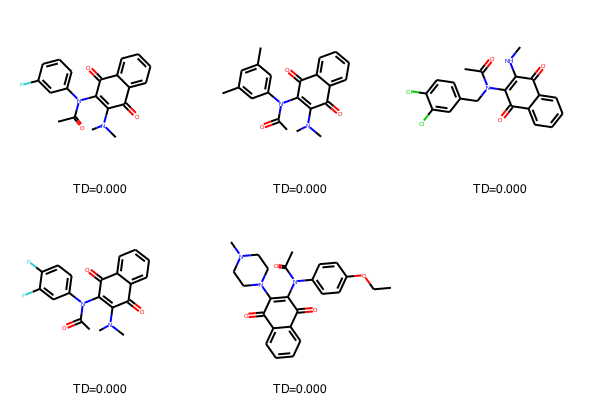

In [98]:
mp_utils.summarize('BEST_D', 5, neighbours=True)

In [99]:
mp_utils.summarize('BEST_D', 5, neighbours=True, draw=False)

(['CC(=O)N(C1=C(N(C)C)C(=O)c2ccccc2C1=O)c1cccc(F)c1',
  'CC(=O)N(C1=C(N(C)C)C(=O)c2ccccc2C1=O)c1cc(C)cc(C)c1',
  'CNC1=C(N(Cc2ccc(Cl)c(Cl)c2)C(C)=O)C(=O)c2ccccc2C1=O',
  'CC(=O)N(C1=C(N(C)C)C(=O)c2ccccc2C1=O)c1ccc(F)c(F)c1',
  'CCOc1ccc(N(C(C)=O)C2=C(N3CCN(C)CC3)C(=O)c3ccccc3C2=O)cc1'],
 ['TD=0.000', 'TD=0.000', 'TD=0.000', 'TD=0.000', 'TD=0.000'])

In [100]:
fig = mp_utils.summarize('BEST_D', 5)
fig.save('figures/best_dist_0.6_from_drugs.png')

In [101]:
#fig = 
#reload(mp_utils)
fig = mp_utils.summarize('BEST_D', 5, check_new=full_df, min_dist=0.2)
fig.save('figures/best_dist_0.6_from_drugs_0.2.png')

In [102]:
fig = mp_utils.summarize('BEST_D', 5, check_new=full_df, neighbours=True, min_dist=0.2)
fig.save('figures/best_dist_0.6_from_drugs_0.2.neighbours.png')

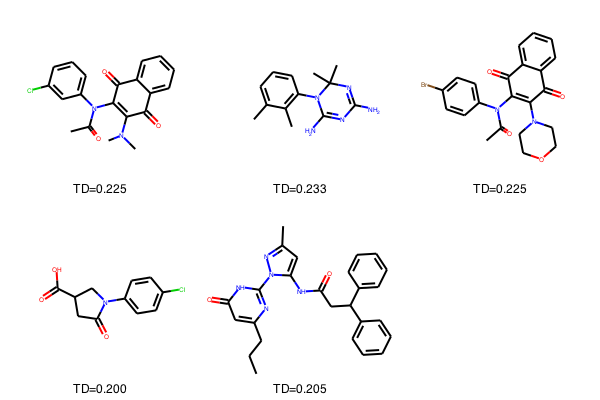

In [103]:
mp_utils.summarize('BEST_D', 5, check_new=full_df, neighbours=True, min_dist=0.2)

In [104]:
fig = mp_utils.summarize('BEST_D', 5, check_new=full_df, neighbours=True, min_dist=0.2)
fig.save('figures/best_dist_0.6_from_drugs_0.2.neighbours.png')

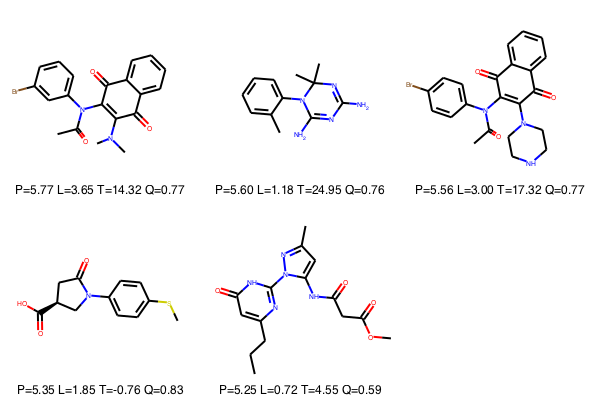

In [105]:
mp_utils.summarize('BEST_D', 5, check_new=full_df, min_dist=0.2)

In [106]:
fig = mp_utils.summarize('BEST_D', 5, check_new=full_df, min_dist=0.2)
fig.save('figures/best_dist_0.6_from_drugs_0.2.png')

In [107]:
reload(mp_utils)
neighbours, mds = mp_utils.summarize('BEST_D', 5, check_new=full_df, neighbours=True, min_dist=0.2, draw=False)

In [108]:
neighbours

['CC(=O)N(C1=C(N(C)C)C(=O)c2ccccc2C1=O)c1cccc(Cl)c1',
 'Cc1cccc(N2C(N)=NC(N)=NC2(C)C)c1C',
 'CC(=O)N(C1=C(N2CCOCC2)C(=O)c2ccccc2C1=O)c1ccc(Br)cc1',
 'O=C(O)C1CC(=O)N(c2ccc(Cl)cc2)C1',
 'CCCc1cc(=O)[nH]c(-n2nc(C)cc2NC(=O)CC(c2ccccc2)c2ccccc2)n1']

In [109]:
mds

['TD=0.225', 'TD=0.233', 'TD=0.225', 'TD=0.200', 'TD=0.205']

In [111]:
def get_neighbour_labels(vals, min_dists):
    labels = []
    for (i, v) in enumerate(vals):
        it = full_df.loc[v]
        lbl = 'P:%.2f L:%.2f Q:%.2f %s' % (it.POTENCY, it.crippen, it.qed, min_dists[i])
        labels.append(lbl)
        pass
    return labels

In [112]:
get_neighbour_labels(neighbours, mds)

['P:7.38 L:3.55 Q:0.83 TD=0.225',
 'P:6.12 L:1.49 Q:0.79 TD=0.233',
 'P:6.66 L:3.43 Q:0.71 TD=0.225',
 'P:6.66 L:1.78 Q:0.86 TD=0.200',
 'P:6.21 L:4.38 Q:0.42 TD=0.205']

In [113]:
nl = get_neighbour_labels(neighbours, mds)

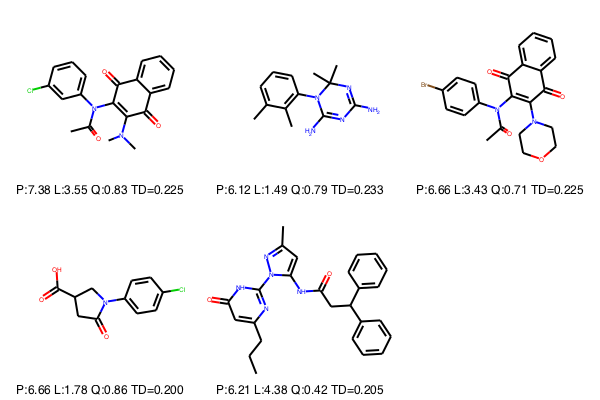

In [114]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in neighbours],legends=nl)

In [115]:
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in neighbours],legends=nl)
fig.save('figures/best_dist_0.6_from_drugs_0.2.neighbours.png')

## Appendix - final stuff.  Putting multiple figures on one plot, making figures bigger, adding stuff

* Check Doxycyline isn't anywhere in our dataset
* Make fonts bigger, and double up on the pictures.
* Provide examples of 'opposite' compounds with activity against PF.

### Bias correction plot

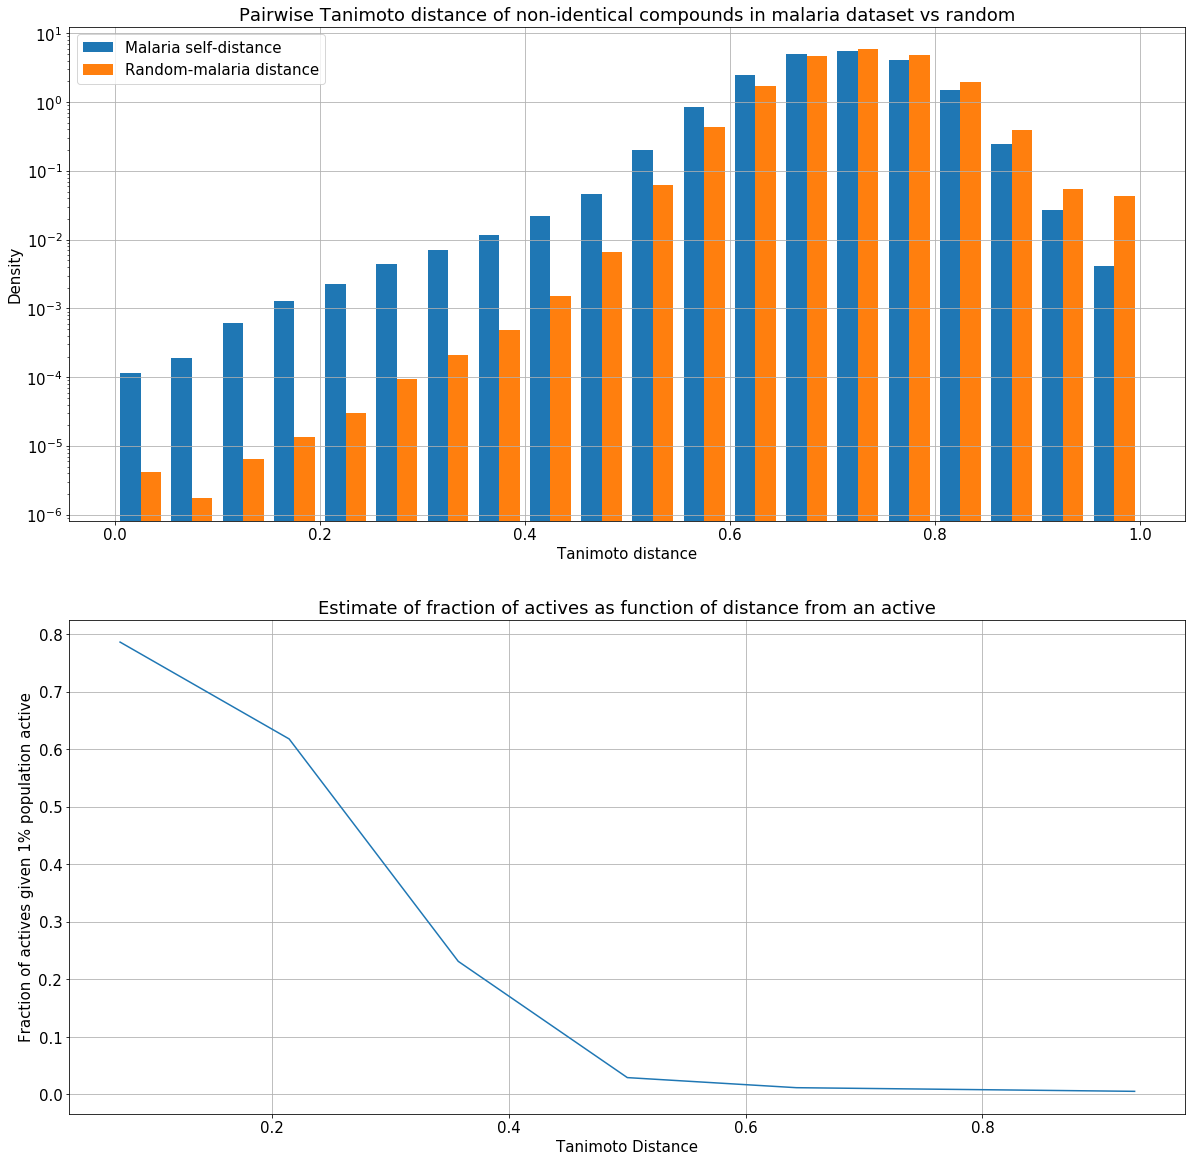

In [139]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(211)
plt.hist((tc_dists[~np.isnan(tc_dists)],tcr_dists[~np.isnan(tcr_dists)]), 
         bins=20, density=True, label=('Malaria self-distance', 'Random-malaria distance'))
#plt.hist(r_dists[~np.isnan(r_dists)], bins=20, label='Random distances')
plt.yscale('log')
plt.xlabel('Tanimoto distance')
plt.ylabel('Density')
plt.grid('True')
plt.legend(loc='best')
plt.title('Pairwise Tanimoto distance of non-identical compounds in malaria dataset vs random')
plt.subplot(212)
plt.plot(x_axis, mal_hist[0]/(100*mr_hist[0]))
plt.grid(True)
plt.xlabel('Tanimoto Distance')
plt.ylabel('Fraction of actives given 1% population active')
_ = plt.title('Estimate of fraction of actives as function of distance from an active')
savefig('figures/fig1_bias_correction.png')

## Model strength + R2 plot...

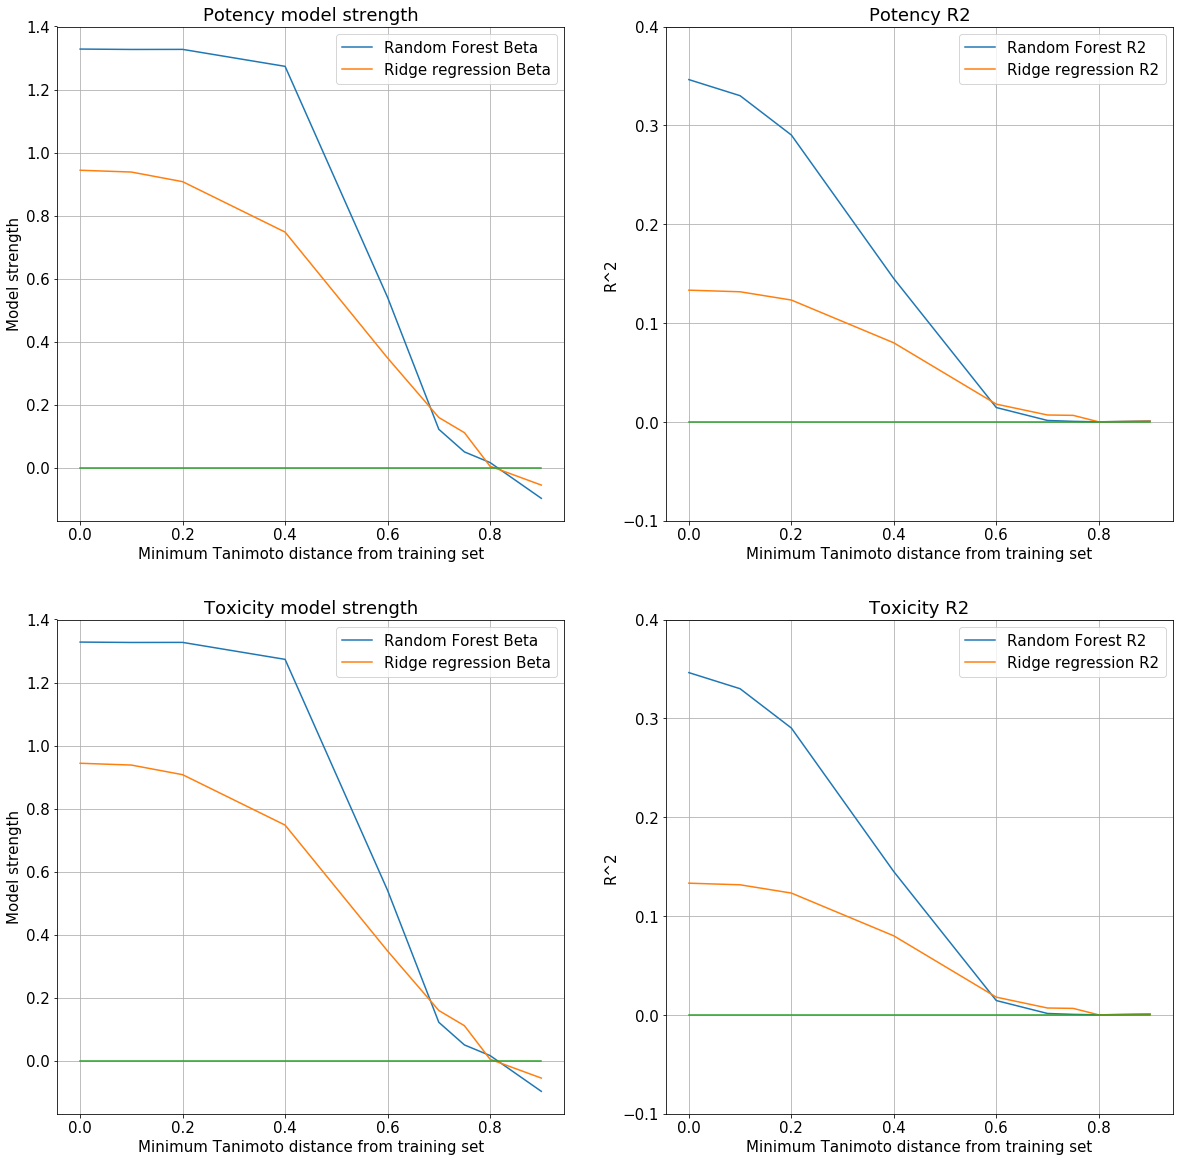

In [134]:
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.75, 0.8, 0.9]
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(221)
plt.plot(bins, result_hdr['rfb'], label='Random Forest Beta')
plt.plot(bins, result_hdr['rdgb'], label='Ridge regression Beta'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('Model strength')
plt.grid(True); plt.legend(loc='best')
plt.title('Potency model strength')
plt.subplot(222)
plt.plot(bins, result_hdr['rf'], label='Random Forest R2')
plt.plot(bins, result_hdr['rdg'], label='Ridge regression R2'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('R^2')
plt.ylim((-0.1, 0.4))
plt.grid(True); plt.legend(loc='best')
plt.title('Potency R2')

result_hdr = joblib.load('results_tox/summary_results')
plt.subplot(223)
plt.plot(bins, result_hdr['rfb'], label='Random Forest Beta')
plt.plot(bins, result_hdr['rdgb'], label='Ridge regression Beta'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('Model strength')
plt.grid(True); plt.legend(loc='best')
plt.title('Toxicity model strength')
plt.subplot(224)
plt.plot(bins, result_hdr['rf'], label='Random Forest R2')
plt.plot(bins, result_hdr['rdg'], label='Ridge regression R2'); 
plt.plot(bins, np.zeros(len(bins)))
plt.xlabel('Minimum Tanimoto distance from training set')
plt.ylabel('R^2')
plt.ylim((-0.1, 0.4))
plt.grid(True); plt.legend(loc='best')
_ = plt.title('Toxicity R2')
savefig('figures/fig2_str_r2.png')

### Histograms...

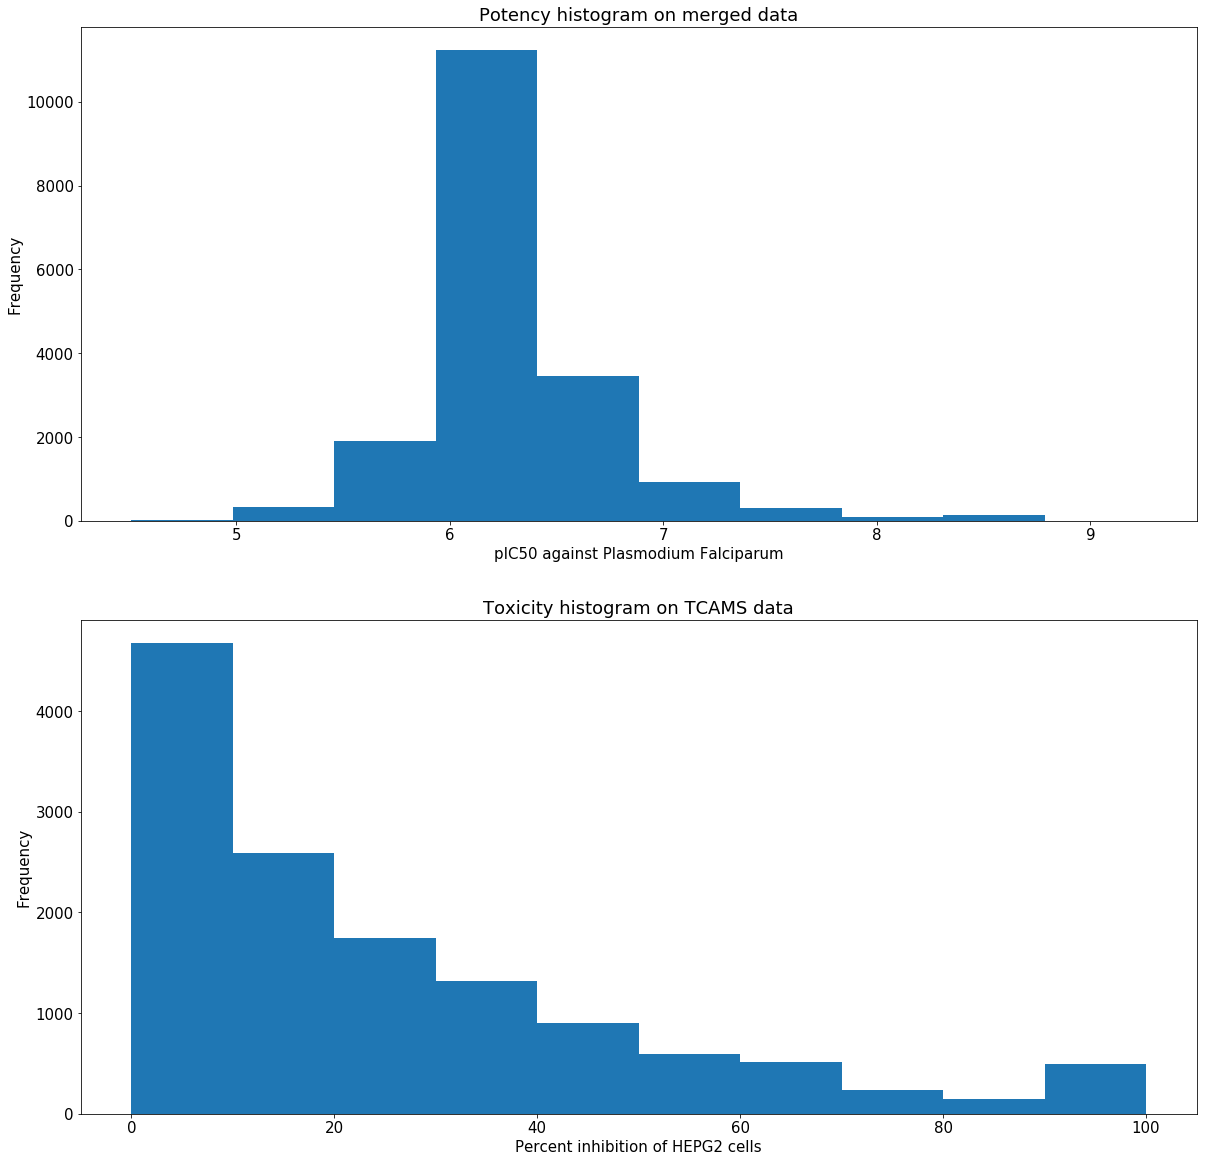

In [137]:
# Figure pot_hist in the paper.
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(211)
full_df.POTENCY.plot.hist()
_ = plt.title('Potency histogram on merged data')
plt.xlabel('pIC50 against Plasmodium Falciparum')
plt.subplot(212)
df_tcams.groupby('SMILESIS').mean()['PCT_INHIB_HEPG2'].plot.hist()
plt.xlabel('Percent inhibition of HEPG2 cells')
_ = plt.title('Toxicity histogram on TCAMS data')
savefig('figures/fig3_hists.png')

### Molecule plots...

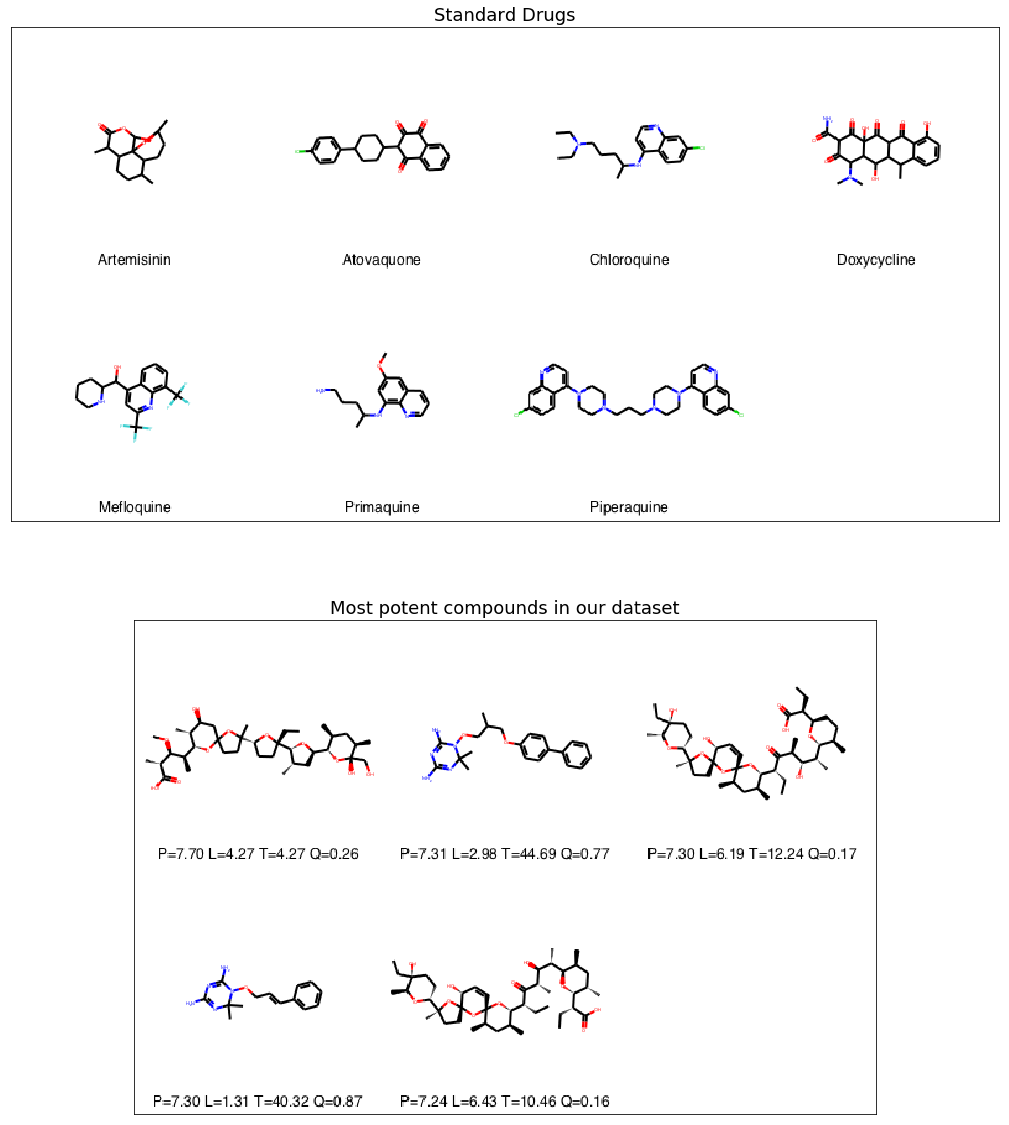

In [156]:
Artemisinin = 'CC1CCC2C(C(=O)OC3C24C1CCC(O3)(OO4)C)C'
Atovaquone  = 'C1CC(CCC1C2=CC=C(C=C2)Cl)C3=C(C4=CC=CC=C4C(=O)C3=O)O'
Chloroquine = 'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl'
Doxycycline = 'CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O'
Mefloquine  = 'C1CCNC(C1)C(C2=CC(=NC3=C2C=CC=C3C(F)(F)F)C(F)(F)F)O'
Primaquine  = 'CC(CCCN)NC1=C2C(=CC(=C1)OC)C=CC=N2'
Piperaquine = 'C1CN(CCN1CCCN2CCN(CC2)C3=C4C=CC(=CC4=NC=C3)Cl)C5=C6C=CC(=CC6=NC=C5)Cl'
drugs = [Artemisinin, Atovaquone, Chloroquine, Doxycycline, Mefloquine, Primaquine, Piperaquine]
drugs = [standardise.run(drug) for drug in drugs]
drug_labels = ['Artemisinin', 'Atovaquone', 'Chloroquine', 
               'Doxycycline', 'Mefloquine', 'Primaquine', 'Piperaquine']

# Figure pot_hist in the paper.
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20))
plt.subplot(211)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in drugs], 
                          legends=drug_labels, molsPerRow=4)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
plt.title('Standard Drugs')
plt.subplot(212)
fig = mp_utils.summarize('POT', 5)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('Most potent compounds in our dataset')
savefig('figures/fig4_drugs_n_pot.png')

### 3 criteria (with neighbours)

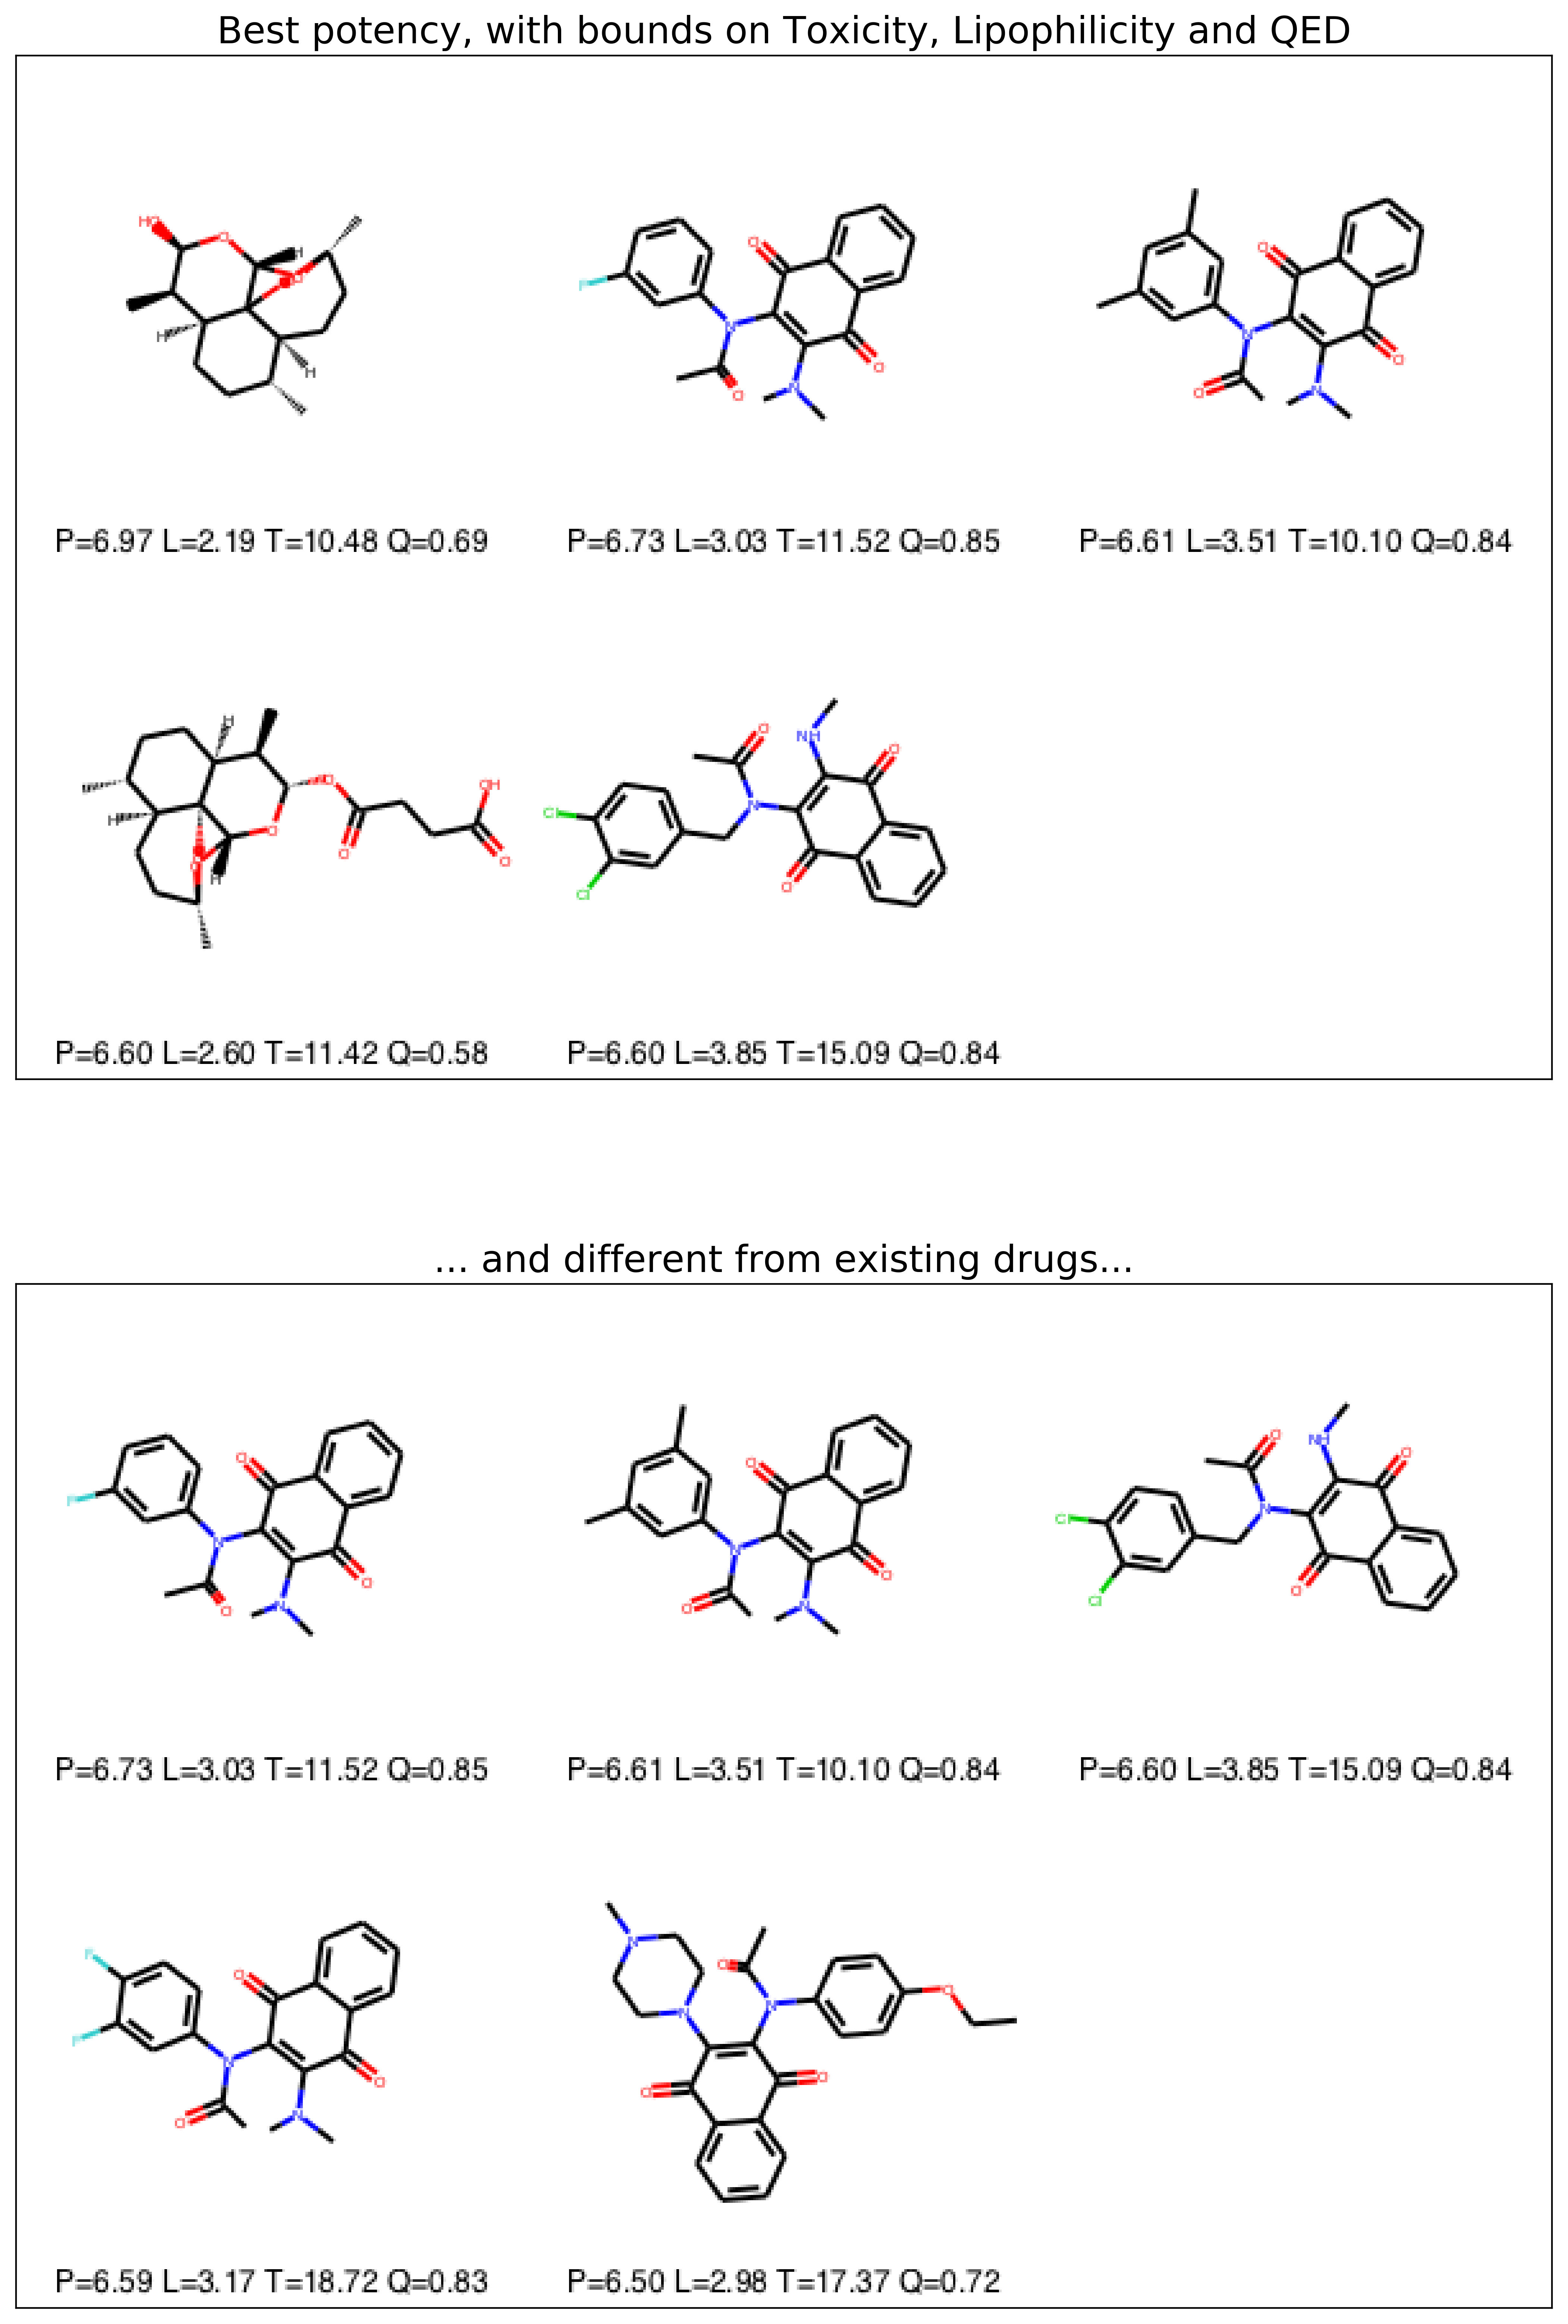

In [166]:
# Figure pot_hist in the paper.
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(211)
fig = mp_utils.summarize('BEST_Q', 5)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
plt.title('Best potency, with bounds on Toxicity, Lipophilicity and QED')
plt.subplot(212)
fig = mp_utils.summarize('BEST_D', 5)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('... and different from existing drugs...')
savefig('figures/fig5.png')

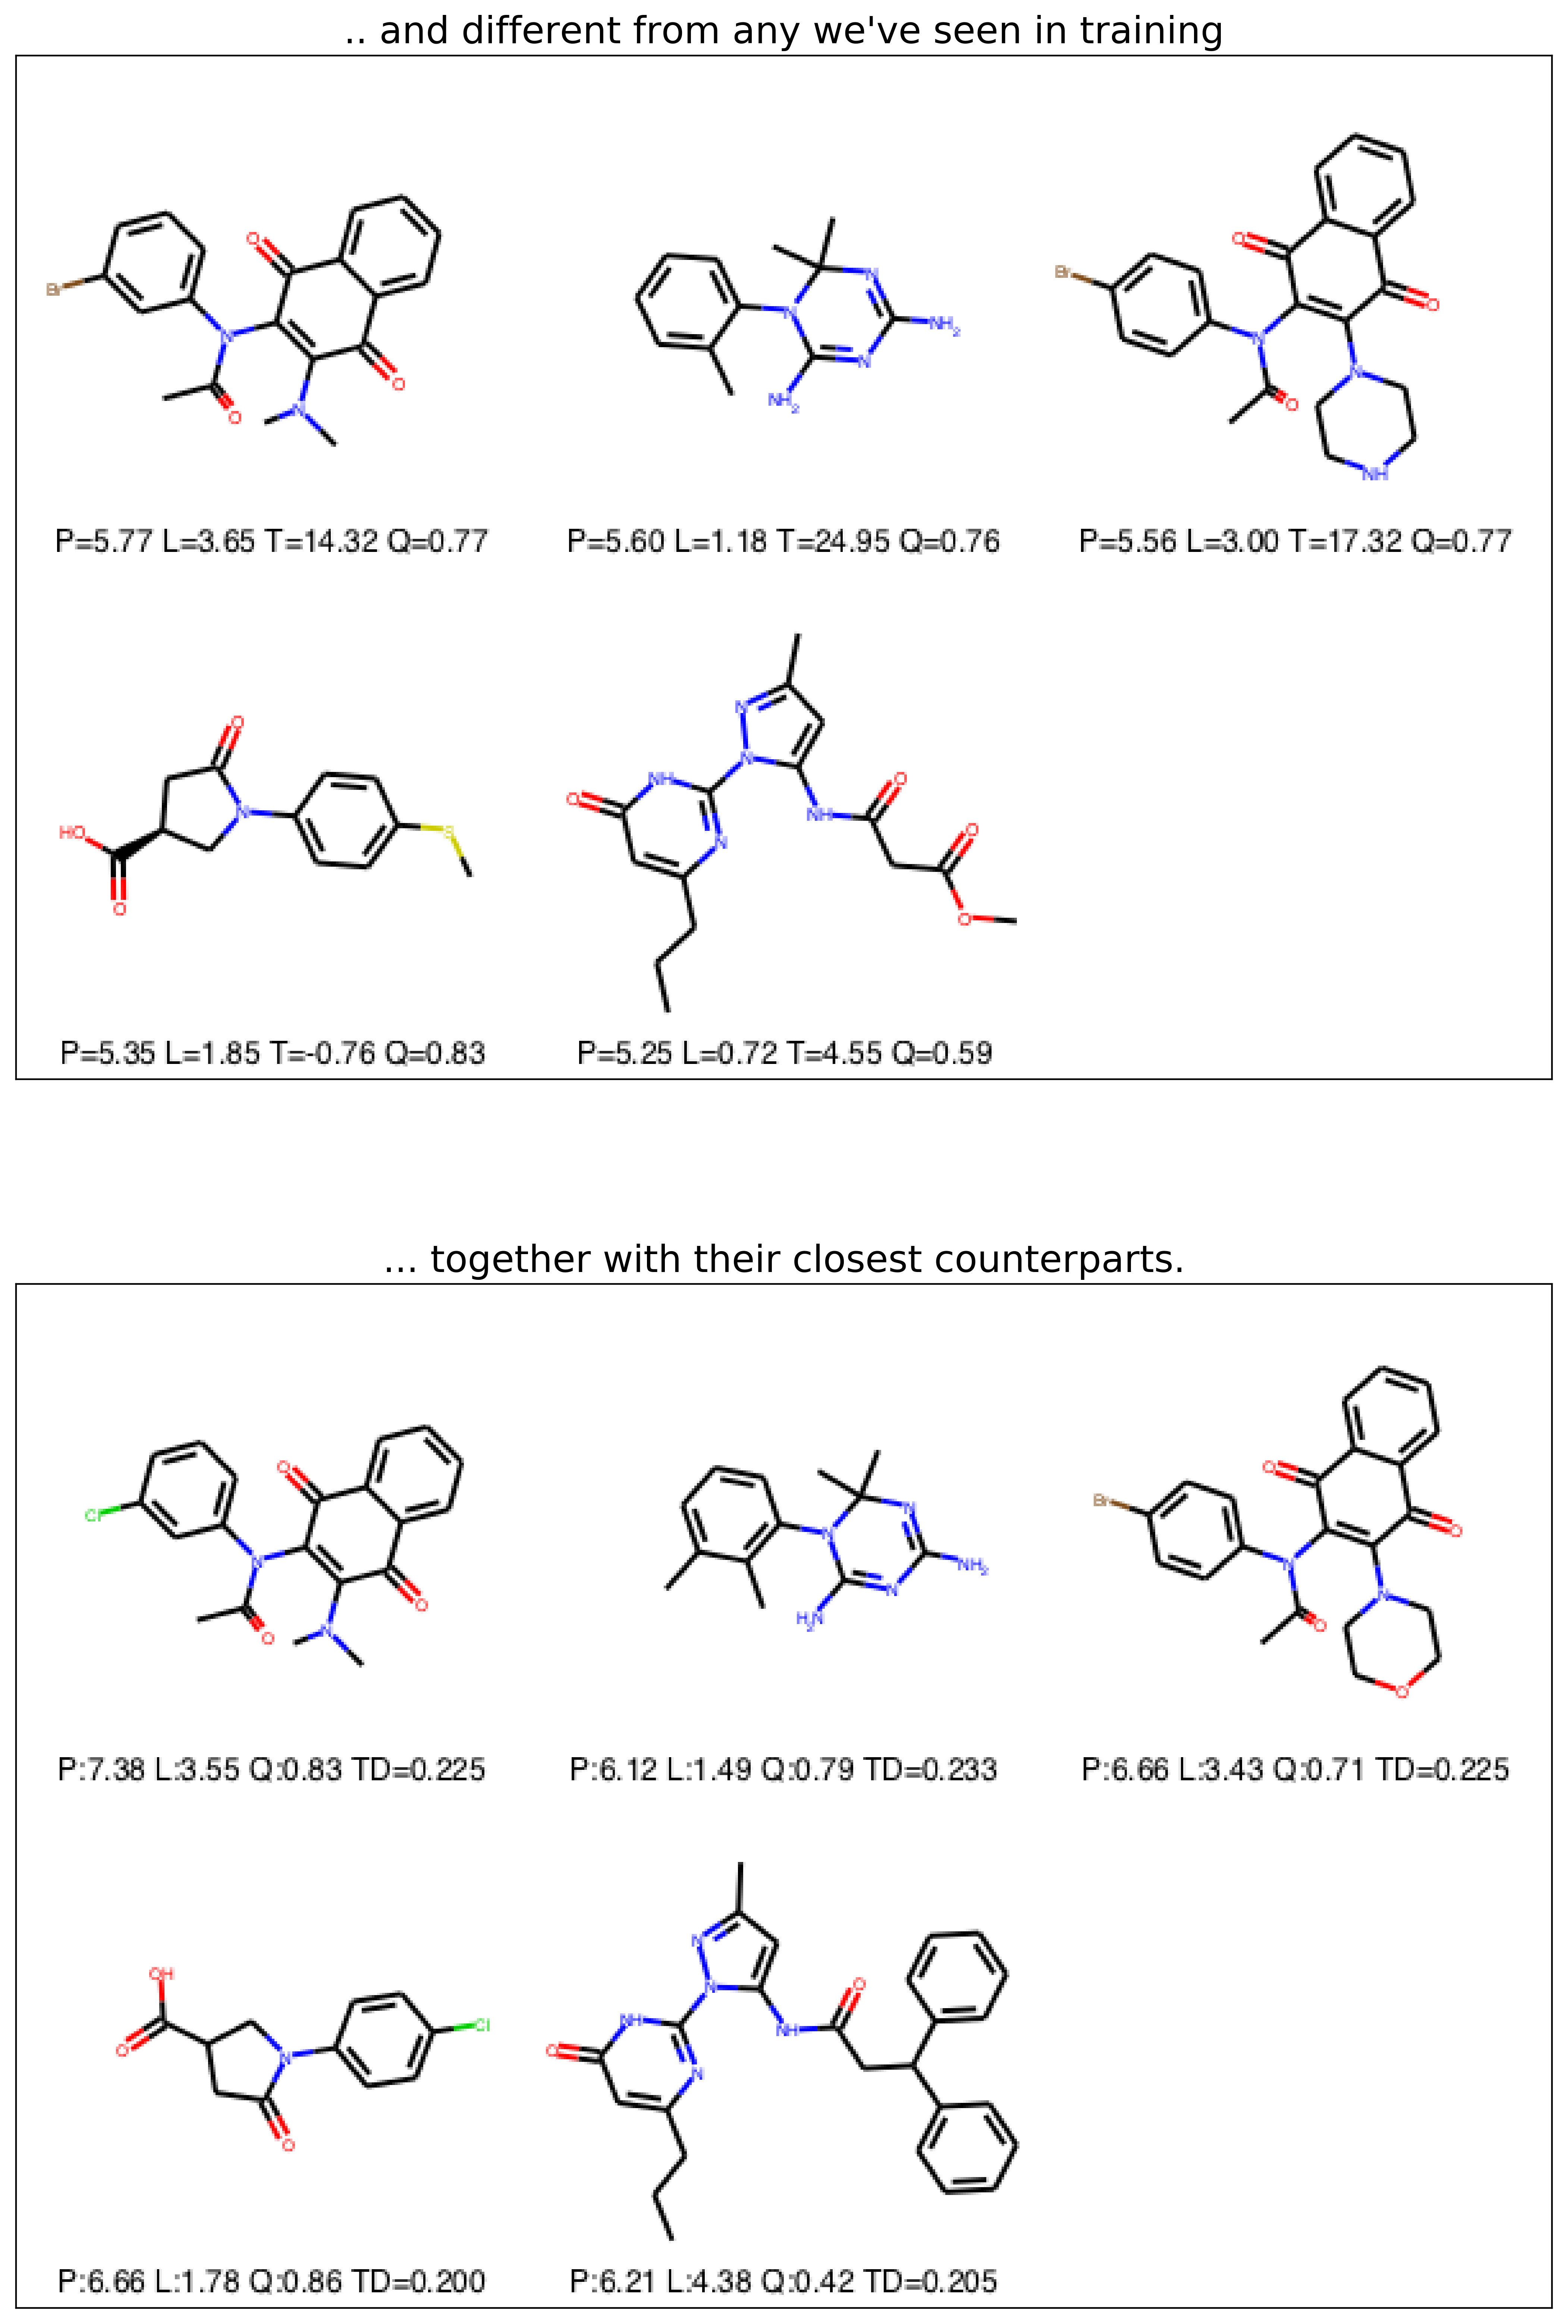

In [167]:
# Figure pot_hist in the paper.
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(211)
fig = mp_utils.summarize('BEST_D', 5, check_new=full_df, min_dist=0.2)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
plt.title(".. and different from any we've seen in training")
neighbours, mds = mp_utils.summarize('BEST_D', 5, check_new=full_df, neighbours=True, min_dist=0.2, draw=False)
nl = get_neighbour_labels(neighbours, mds)
plt.subplot(212)
fig = Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in neighbours],legends=nl)
plt.imshow(fig)
plt.xticks([])
plt.yticks([])
_ = plt.title('... together with their closest counterparts in training set.')
savefig('figures/fig6.png')

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less_equal


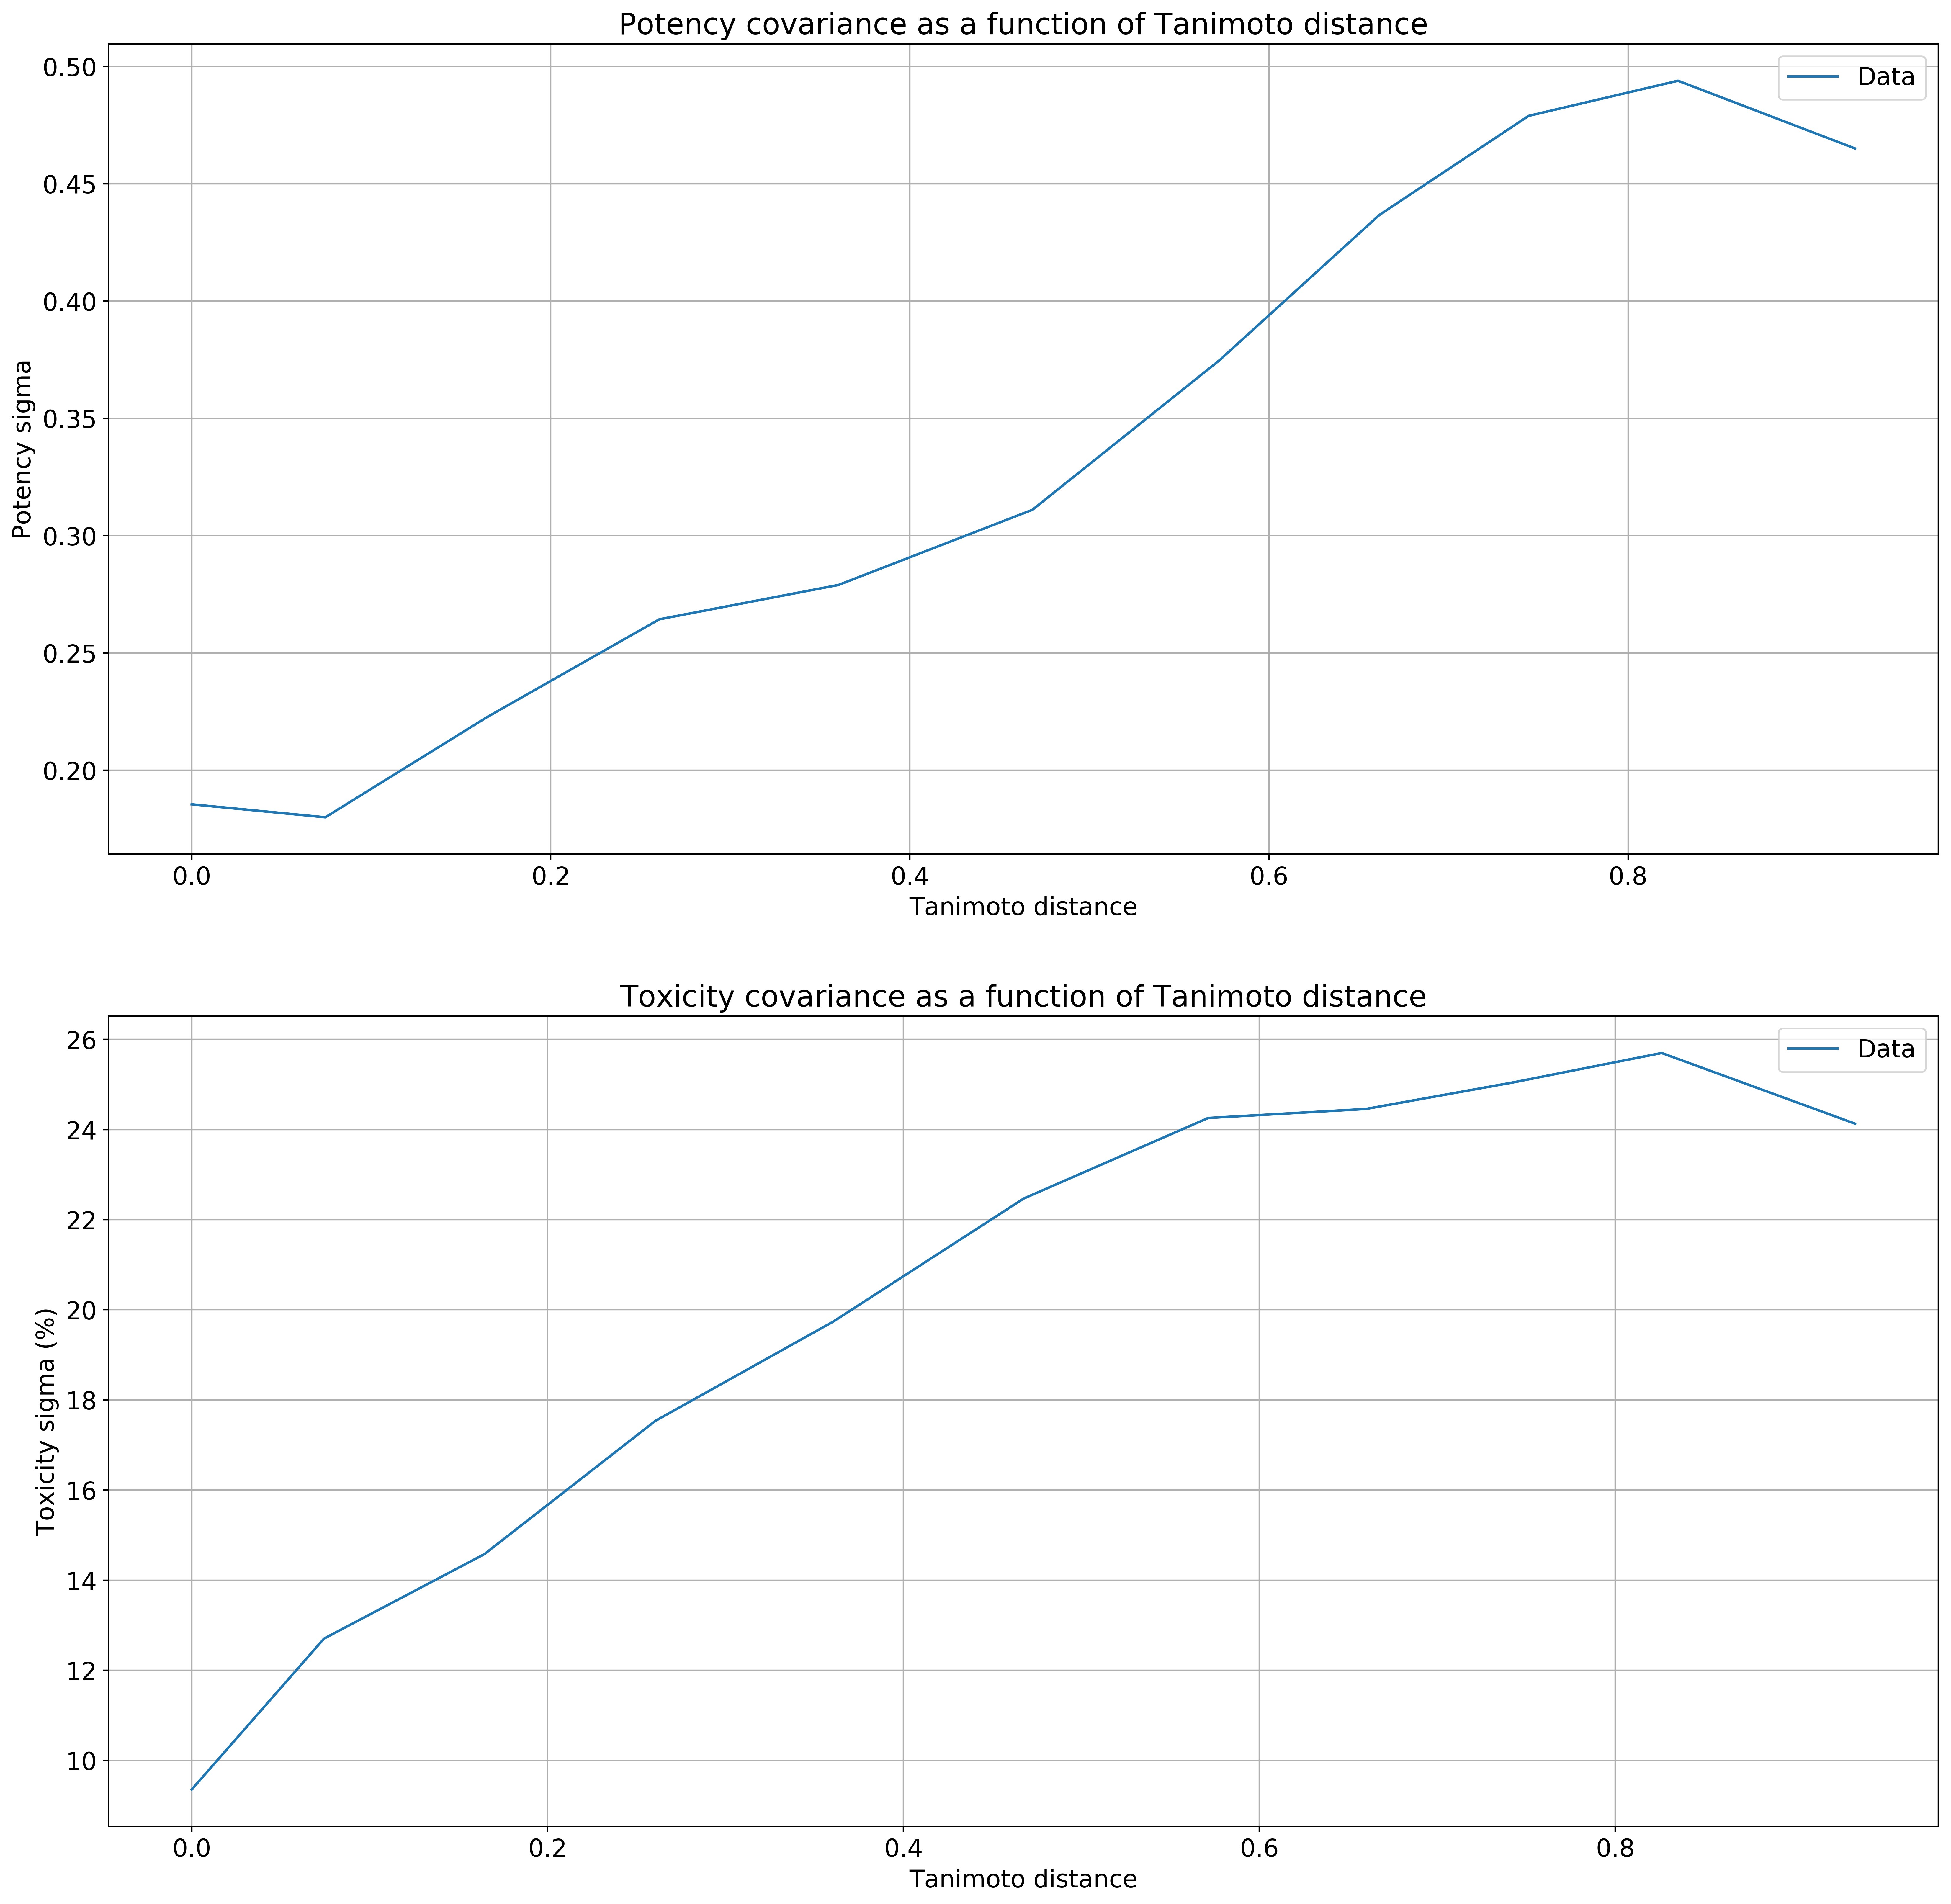

In [170]:
estimates_hdr = {}
weight_hdr = {}
ctr_hdr = {}

bins = [-0.001, 0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for i in range(len(bins)-1):
    estimates_hdr[i] = []
    weight_hdr[i] = []
    ctr_hdr[i] = []
    pass

for i in range(full_df.shape[0]):
    v = [full_df.POTENCY.values[i]]
    dists = cdist(np.asarray([full_df.fps.values[i],]), fpa, metric='jaccard')[0]
    dists[i]+=2 # to exclude from anything
    
    for j in range(len(bins)-1):
        bstart = bins[j]
        bend = bins[j+1]
        gd = (dists > bstart) & (dists <= bend)
        gpot = full_df.POTENCY.values[gd]
        if len(gpot) == 0:
            continue

        gpot = np.concatenate((v, gpot))
        estimates_hdr[j].append(np.std(gpot, ddof=1))
        weight_hdr[j].append(gpot.shape[0]-1)
        ctr_hdr[j].append(np.mean(dists[gd]))
        pass
    pass     

ctrs = np.asarray([np.average(ctr_hdr[i], weights=weight_hdr[i]) for i in range(len(bins)-1)])
sigmas = np.asarray([np.average(estimates_hdr[i], weights=weight_hdr[i]) for i in range(len(bins)-1)])

#stats.run_suite(df_tcams_nd, 'PCT_INHIB_HEPG2', add_pred=df_tcams_nd.crippen.values[:,None])

estimates_tox_hdr = {}
weight_tox_hdr = {}
ctr_tox_hdr = {}

bins = [-0.001, 0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
df_tox = df_tcams_nd.dropna(subset=['PCT_INHIB_HEPG2'])
fpat = np.asarray([x for x in df_tox.fps.values])


for i in range(len(bins)-1):
    estimates_tox_hdr[i] = []
    weight_tox_hdr[i] = []
    ctr_tox_hdr[i] = []
    pass

for i in range(df_tox.shape[0]):
    v = [df_tox.PCT_INHIB_HEPG2.values[i]]
    dists = cdist(np.asarray([df_tox.fps.values[i],]), fpat, metric='jaccard')[0]
    dists[i]+=2 # to exclude from anything
    
    for j in range(len(bins)-1):
        bstart = bins[j]
        bend = bins[j+1]
        gd = (dists > bstart) & (dists <= bend)
        gpot = df_tox.PCT_INHIB_HEPG2.values[gd]
        if len(gpot) == 0:
            continue

        gpot = np.concatenate((v, gpot))
        estimates_tox_hdr[j].append(np.std(gpot, ddof=1))
        weight_tox_hdr[j].append(gpot.shape[0]-1)
        ctr_tox_hdr[j].append(np.mean(dists[gd]))
        pass
    pass        


ctrst = np.asarray([np.average(ctr_tox_hdr[i], weights=weight_tox_hdr[i]) for i in range(len(bins)-1)])
sigmast = np.asarray([np.average(estimates_tox_hdr[i], weights=weight_tox_hdr[i]) for i in range(len(bins)-1)])

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 20), dpi=400)
plt.subplot(211)
plt.plot(ctrs, sigmas, label='Data'); grid(True); xlabel('Tanimoto distance'); ylabel('Potency sigma')
legend(loc='best')
_ = title('Potency covariance as a function of Tanimoto distance')
plt.subplot(212)
plt.plot(ctrst, sigmast, label='Data'); grid(True); xlabel('Tanimoto distance'); ylabel('Toxicity sigma (%)')
legend(loc='best')
_ = title('Toxicity covariance as a function of Tanimoto distance')
savefig('figures/fig2_covariance.jpg')